In [1]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [2]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [3]:
from PIL import Image
import os

Custom Dataset is the class created that inherits Dataset class and overrides its methods. This class takes as input the path of which contains all the class folders.

The init loops through and gets all the folder name as class name. Then for each class folder is looped through and the image name is stored along with the path of each image along with the class name of each image and their labels.
This lists are transformed into to create a pandas dataframe. Which really isnt used here but can be used as a reference to all files neatly.

The getitem just get some image based on index and respective label and returns both. The image can be applied any form of transformation by just applying the transform method of Dataset class on that image.

The len method returns the number of images.

In [7]:
from torch.utils.data import Dataset
import pandas as pd
import os

class CustomDataset(Dataset):

  def __init__(self, the_path, transform = None):
    self.the_path = the_path
    classdir = os.listdir(self.the_path)

    names = []
    paths = []
    classes = []
    label = []

    for i in classdir:
      class_path = the_path + str('/' + i)
      for j in os.listdir(class_path):
        names.append(j)
        paths.append(class_path + str('/' + j))
        classes.append(i)
        label.append(classdir.index(i))
    
    data = {'Name' : names, 'Path' : paths, 'Class' : classes, 'Label' : label}
    df = pd.DataFrame(data)
  
    self.img_name = df['Name']
    self.label = df['Label']
    self.transform = transform
    self.path = df['Path']
  
  def __getitem__(self, index):
    img = Image.open(self.path[index])

    if(self.transform is not None):
      img = self.transform(img)

    label = self.label[index]
    return img, label

  def __len__(self):
    return len(self.label)

In [9]:
path = "../WGAN/CIFAR-10-images-master/train"

Normal transformation is applied on the dataset

In [10]:
import torchvision.datasets as datasets
train_data = CustomDataset(path,
    transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [11]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

The image sare denormalized in output to resemble original image.

In [12]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

Show image by batch. Following methods are applied.

In [13]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=16).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

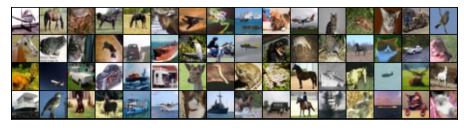

In [14]:
show_batch(train_dl)

Helper Functions

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)

In [18]:
import torch.nn as nn

Discriminator taking input a 64 * 64 RGB image and outputs wheather the image is real or fake.

In [19]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
)

In [20]:
discriminator = to_device(discriminator, device)

The noise vector size that is given input to the generator.

In [21]:
latent_size = 128

The generator takes in input the 128 length noise vector and outputs a 64 * 64 RGB image.

In [22]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

Method for initializing weights of both discriminator and generator. According to paper this is how random weights are to be initialized.

In [23]:
def weight_init(m):
    # weight_initialization: important for wgan
    class_name=m.__class__.__name__
    if class_name.find('Conv')!=-1:
        m.weight.data.normal_(0,0.02)
    elif class_name.find('Norm')!=-1:
        m.weight.data.normal_(1.0,0.02)

In [24]:
discriminator.apply(weight_init)
generator.apply(weight_init)

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

torch.Size([128, 3, 64, 64])


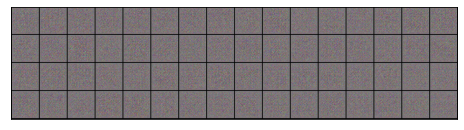

In [25]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [26]:
generator = to_device(generator, device)

The following method is for training discriminator. This takes the image batch given by the dataloader and the optimizer for this network.

The loss for real batch of images is calculated by calculating as the mean of the predictions by the discriminator.

Then a random noise vector is passed to the generator to get fake image batch. This image batch is again passed to the discriminator to get the loss similarly.

The total loss is the loss of the generator. This loss is used for updating weights along with the optimizer specified for this network.

The total loss along with real and fake loss is returned.

In [27]:
def train_discriminator(real_images, opt_d):

    opt_d.zero_grad()


    real_preds = discriminator(real_images)

    real_loss = -torch.mean(real_preds)
        
   
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_preds = discriminator(fake_images)
       
    fake_loss = torch.mean(fake_preds)

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_loss.item(), fake_loss.item()

The input to the generator is the optimizer for this network. The generator is trained by generating batch of image from the noise vector.

This genearted image is passed to the discriminator to get the prediction and the generator wants to maximize the loss of the generator.

The loss is therefore assigned negative. This loss is then used for backpropagation along with optimizer for the network. Returns loss of generator.

In [28]:
def train_generator(opt_g):
    
    opt_g.zero_grad()
    
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    
    preds = discriminator(fake_images)
    
    loss = -torch.mean(preds)
    
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [29]:
from torchvision.utils import save_image

In [30]:
sample_directory = "../WGAN/output10" 

Helper method that saves output to folder.

In [31]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    save_image(denorm(fake_images), sample_directory + f"/output{index}.png", nrow=8)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [32]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


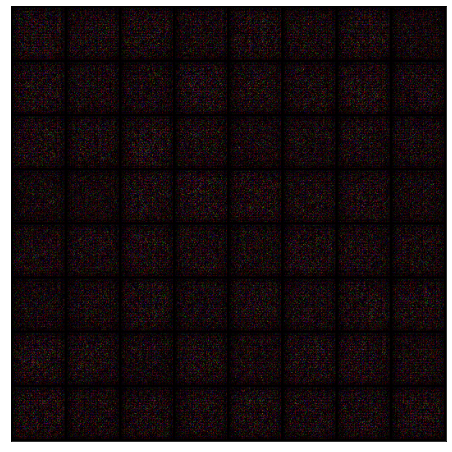

In [33]:
save_samples(0, fixed_latent)

In [34]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

The method that does the looping for a number of epochs for each batch of data.

The optimizer used for generator and discriminator is both RMS Prop as per paper.

The parameters of discriminator is clipped so that the parameters of the discriminators are between -0.1 and 0.1. Clipping is important part of WGAN.

The loss of each discriminator and generator. The fake and real image scores.

In [35]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # optimizers
    opt_d = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
    opt_g = torch.optim.RMSprop(generator.parameters(), lr=lr)
    
    
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            
            for parm in discriminator.parameters():
                parm.data.clamp_(-clamp_num, clamp_num)
                
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [36]:
lr = 0.00005
epochs = 1000
clamp_num=0.01# WGAN clip gradient

In [37]:
history = fit(epochs, lr)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1/1000], loss_g: 0.4183, loss_d: -0.8492, real_score: -0.4474, fake_score: -0.4018


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [2/1000], loss_g: 0.4392, loss_d: -0.8346, real_score: -0.5071, fake_score: -0.3275


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [3/1000], loss_g: 0.0773, loss_d: -0.5448, real_score: -0.1091, fake_score: -0.4357


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [4/1000], loss_g: 0.3591, loss_d: -0.6359, real_score: -0.4298, fake_score: -0.2061


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [5/1000], loss_g: -0.0061, loss_d: -0.3326, real_score: 0.1508, fake_score: -0.4834


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [6/1000], loss_g: 0.0255, loss_d: -0.4805, real_score: -0.0420, fake_score: -0.4386


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [7/1000], loss_g: 0.2210, loss_d: -0.4994, real_score: -0.2590, fake_score: -0.2403


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [8/1000], loss_g: 0.3032, loss_d: -0.5830, real_score: -0.3697, fake_score: -0.2133


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [9/1000], loss_g: 0.0329, loss_d: -0.4976, real_score: -0.1706, fake_score: -0.3270


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [10/1000], loss_g: 0.2149, loss_d: -0.5362, real_score: -0.3095, fake_score: -0.2267


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [11/1000], loss_g: 0.1819, loss_d: -0.5059, real_score: -0.2934, fake_score: -0.2125


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [12/1000], loss_g: 0.2788, loss_d: -0.4320, real_score: -0.3507, fake_score: -0.0813


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [13/1000], loss_g: 0.3469, loss_d: -0.3646, real_score: -0.4127, fake_score: 0.0481


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [14/1000], loss_g: 0.3765, loss_d: -0.3172, real_score: -0.4704, fake_score: 0.1533


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [15/1000], loss_g: -0.0916, loss_d: -0.2229, real_score: 0.0741, fake_score: -0.2970


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [16/1000], loss_g: 0.3520, loss_d: -0.2936, real_score: -0.4611, fake_score: 0.1675


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [17/1000], loss_g: 0.3835, loss_d: -0.3227, real_score: -0.4356, fake_score: 0.1129


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [18/1000], loss_g: 0.0253, loss_d: -0.2415, real_score: 0.0819, fake_score: -0.3233


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [19/1000], loss_g: 0.2448, loss_d: -0.2345, real_score: -0.3585, fake_score: 0.1240


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [20/1000], loss_g: 0.3218, loss_d: -0.3893, real_score: -0.3605, fake_score: -0.0289


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [21/1000], loss_g: 0.1123, loss_d: -0.3601, real_score: -0.2158, fake_score: -0.1442


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [22/1000], loss_g: 0.3300, loss_d: -0.2834, real_score: -0.4308, fake_score: 0.1474


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [23/1000], loss_g: -0.1639, loss_d: -0.2852, real_score: 0.0201, fake_score: -0.3053


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [24/1000], loss_g: -0.3509, loss_d: -0.2585, real_score: 0.0573, fake_score: -0.3159


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [25/1000], loss_g: 0.2012, loss_d: -0.1874, real_score: -0.5080, fake_score: 0.3206


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [26/1000], loss_g: 0.3956, loss_d: -0.2341, real_score: -0.4600, fake_score: 0.2258


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [27/1000], loss_g: 0.3643, loss_d: -0.2755, real_score: -0.4748, fake_score: 0.1993


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [28/1000], loss_g: 0.0502, loss_d: -0.3224, real_score: -0.1015, fake_score: -0.2209


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [29/1000], loss_g: 0.3659, loss_d: -0.2496, real_score: -0.4169, fake_score: 0.1672


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [30/1000], loss_g: -0.1010, loss_d: -0.2115, real_score: 0.1192, fake_score: -0.3307


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [31/1000], loss_g: -0.0515, loss_d: -0.2916, real_score: 0.0303, fake_score: -0.3220


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [32/1000], loss_g: 0.2627, loss_d: -0.3841, real_score: -0.2707, fake_score: -0.1135


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [33/1000], loss_g: 0.3372, loss_d: -0.3952, real_score: -0.3418, fake_score: -0.0534


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [34/1000], loss_g: 0.1899, loss_d: -0.3296, real_score: -0.1990, fake_score: -0.1306


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [35/1000], loss_g: 0.3789, loss_d: -0.3222, real_score: -0.4557, fake_score: 0.1336


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [36/1000], loss_g: -0.0252, loss_d: -0.2693, real_score: 0.0687, fake_score: -0.3380


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [37/1000], loss_g: 0.1599, loss_d: -0.4627, real_score: -0.2919, fake_score: -0.1708


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [38/1000], loss_g: 0.4068, loss_d: -0.3701, real_score: -0.4709, fake_score: 0.1007


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [39/1000], loss_g: 0.3749, loss_d: -0.2847, real_score: -0.4697, fake_score: 0.1849


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [40/1000], loss_g: -0.1152, loss_d: -0.3101, real_score: -0.0387, fake_score: -0.2715


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [41/1000], loss_g: 0.3343, loss_d: -0.1918, real_score: -0.4831, fake_score: 0.2913


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [42/1000], loss_g: 0.3573, loss_d: -0.3032, real_score: -0.4078, fake_score: 0.1046


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [43/1000], loss_g: 0.3379, loss_d: -0.2182, real_score: -0.5133, fake_score: 0.2951


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [44/1000], loss_g: 0.0499, loss_d: -0.4788, real_score: -0.2457, fake_score: -0.2331


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [45/1000], loss_g: 0.0230, loss_d: -0.3337, real_score: -0.1022, fake_score: -0.2315


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [46/1000], loss_g: 0.0937, loss_d: -0.2253, real_score: 0.1153, fake_score: -0.3406


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [47/1000], loss_g: -0.2604, loss_d: -0.2349, real_score: 0.0720, fake_score: -0.3070


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [48/1000], loss_g: 0.4227, loss_d: -0.3784, real_score: -0.5267, fake_score: 0.1483


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [49/1000], loss_g: -0.1427, loss_d: -0.2422, real_score: 0.1233, fake_score: -0.3656


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [50/1000], loss_g: -0.1455, loss_d: -0.2732, real_score: 0.1107, fake_score: -0.3839


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [51/1000], loss_g: 0.4464, loss_d: -0.5573, real_score: -0.4736, fake_score: -0.0837


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [52/1000], loss_g: 0.0414, loss_d: -0.4722, real_score: -0.2345, fake_score: -0.2377


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [53/1000], loss_g: 0.3911, loss_d: -0.3236, real_score: -0.4813, fake_score: 0.1576


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [54/1000], loss_g: -0.0573, loss_d: -0.3949, real_score: -0.0972, fake_score: -0.2977


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [55/1000], loss_g: 0.4745, loss_d: -0.3538, real_score: -0.5375, fake_score: 0.1837


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [56/1000], loss_g: 0.3307, loss_d: -0.2431, real_score: -0.4795, fake_score: 0.2364


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [57/1000], loss_g: 0.4093, loss_d: -0.2879, real_score: -0.5070, fake_score: 0.2191


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [58/1000], loss_g: 0.4531, loss_d: -0.3636, real_score: -0.4471, fake_score: 0.0835


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [59/1000], loss_g: -0.1508, loss_d: -0.3350, real_score: 0.0047, fake_score: -0.3397


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [60/1000], loss_g: 0.3703, loss_d: -0.2621, real_score: -0.4504, fake_score: 0.1883


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [61/1000], loss_g: 0.2756, loss_d: -0.3104, real_score: -0.3251, fake_score: 0.0147


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [62/1000], loss_g: -0.2047, loss_d: -0.2462, real_score: 0.1568, fake_score: -0.4030


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [63/1000], loss_g: 0.3931, loss_d: -0.6120, real_score: -0.4325, fake_score: -0.1795


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [64/1000], loss_g: 0.3580, loss_d: -0.3024, real_score: -0.4265, fake_score: 0.1241


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [65/1000], loss_g: 0.0109, loss_d: -0.2768, real_score: 0.0468, fake_score: -0.3236


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [66/1000], loss_g: 0.4438, loss_d: -0.5728, real_score: -0.4455, fake_score: -0.1274


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [67/1000], loss_g: -0.1988, loss_d: -0.2149, real_score: 0.1134, fake_score: -0.3283


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [68/1000], loss_g: 0.2336, loss_d: -0.6156, real_score: -0.3799, fake_score: -0.2356


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [69/1000], loss_g: 0.2509, loss_d: -0.0997, real_score: 0.3549, fake_score: -0.4546


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [70/1000], loss_g: -0.0973, loss_d: -0.3046, real_score: 0.0796, fake_score: -0.3843


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [71/1000], loss_g: 0.0379, loss_d: -0.1520, real_score: 0.2892, fake_score: -0.4412


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [72/1000], loss_g: -0.0595, loss_d: -0.3280, real_score: -0.1032, fake_score: -0.2249


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [73/1000], loss_g: 0.4513, loss_d: -0.3504, real_score: -0.5082, fake_score: 0.1578


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [74/1000], loss_g: -0.1855, loss_d: -0.2577, real_score: 0.0765, fake_score: -0.3343


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [75/1000], loss_g: -0.1093, loss_d: -0.1783, real_score: 0.2098, fake_score: -0.3881


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [76/1000], loss_g: -0.0908, loss_d: -0.2697, real_score: 0.0782, fake_score: -0.3479


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [77/1000], loss_g: 0.3950, loss_d: -0.1637, real_score: -0.1632, fake_score: -0.0005


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [78/1000], loss_g: 0.2919, loss_d: -0.5808, real_score: -0.3038, fake_score: -0.2770


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [79/1000], loss_g: 0.3863, loss_d: -0.3197, real_score: -0.4506, fake_score: 0.1309


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [80/1000], loss_g: -0.0354, loss_d: -0.2605, real_score: -0.2036, fake_score: -0.0570


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [81/1000], loss_g: 0.1372, loss_d: -0.1339, real_score: -0.5392, fake_score: 0.4053


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [82/1000], loss_g: 0.3415, loss_d: -0.6029, real_score: -0.4311, fake_score: -0.1718


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [83/1000], loss_g: -0.3317, loss_d: -0.1920, real_score: 0.1531, fake_score: -0.3452


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [84/1000], loss_g: 0.4551, loss_d: -0.3073, real_score: -0.4458, fake_score: 0.1385


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [85/1000], loss_g: -0.1419, loss_d: -0.4778, real_score: -0.1757, fake_score: -0.3021


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [86/1000], loss_g: 0.5096, loss_d: -0.4916, real_score: -0.5332, fake_score: 0.0416


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [87/1000], loss_g: 0.2234, loss_d: -0.6675, real_score: -0.3886, fake_score: -0.2790


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [88/1000], loss_g: 0.1248, loss_d: -0.3909, real_score: -0.2053, fake_score: -0.1855


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [89/1000], loss_g: 0.3448, loss_d: -0.1793, real_score: -0.5775, fake_score: 0.3982


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [90/1000], loss_g: 0.4266, loss_d: -0.2941, real_score: -0.5162, fake_score: 0.2221


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [91/1000], loss_g: 0.4744, loss_d: -0.3811, real_score: -0.4535, fake_score: 0.0724


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [92/1000], loss_g: 0.2184, loss_d: -0.5249, real_score: -0.3471, fake_score: -0.1778


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [93/1000], loss_g: 0.3415, loss_d: -0.5787, real_score: -0.4238, fake_score: -0.1549


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [94/1000], loss_g: 0.0340, loss_d: -0.1600, real_score: 0.2467, fake_score: -0.4067


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [95/1000], loss_g: 0.4385, loss_d: -0.6394, real_score: -0.4812, fake_score: -0.1583


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [96/1000], loss_g: 0.3407, loss_d: -0.6508, real_score: -0.3843, fake_score: -0.2665


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [97/1000], loss_g: 0.1858, loss_d: -0.2158, real_score: -0.3503, fake_score: 0.1345


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [98/1000], loss_g: 0.3703, loss_d: -0.2297, real_score: -0.4780, fake_score: 0.2483


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [99/1000], loss_g: -0.2863, loss_d: -0.3474, real_score: -0.0725, fake_score: -0.2749


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [100/1000], loss_g: 0.4061, loss_d: -0.3117, real_score: -0.4923, fake_score: 0.1806


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [101/1000], loss_g: 0.3041, loss_d: -0.3696, real_score: -0.3416, fake_score: -0.0279


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [102/1000], loss_g: -0.0823, loss_d: -0.1619, real_score: 0.1290, fake_score: -0.2909


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [103/1000], loss_g: 0.3306, loss_d: -0.3910, real_score: -0.3423, fake_score: -0.0487


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [104/1000], loss_g: 0.3309, loss_d: -0.0804, real_score: 0.3868, fake_score: -0.4672


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [105/1000], loss_g: 0.3686, loss_d: -0.5732, real_score: -0.3670, fake_score: -0.2062


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [106/1000], loss_g: -0.2849, loss_d: -0.2909, real_score: 0.1260, fake_score: -0.4169


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [107/1000], loss_g: 0.3040, loss_d: -0.3095, real_score: -0.3109, fake_score: 0.0013


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [108/1000], loss_g: 0.2110, loss_d: -0.6666, real_score: -0.3905, fake_score: -0.2761


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [109/1000], loss_g: 0.4984, loss_d: -0.3394, real_score: -0.5361, fake_score: 0.1967


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [110/1000], loss_g: 0.2338, loss_d: -0.1659, real_score: -0.5047, fake_score: 0.3388


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [111/1000], loss_g: 0.4632, loss_d: -0.6417, real_score: -0.4818, fake_score: -0.1599


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [112/1000], loss_g: -0.3204, loss_d: -0.2414, real_score: 0.1497, fake_score: -0.3911


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [113/1000], loss_g: -0.0718, loss_d: -0.2282, real_score: 0.1734, fake_score: -0.4015


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [114/1000], loss_g: -0.1343, loss_d: -0.1646, real_score: 0.2502, fake_score: -0.4148


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [115/1000], loss_g: -0.0280, loss_d: -0.1655, real_score: -0.0042, fake_score: -0.1613


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [116/1000], loss_g: -0.0069, loss_d: -0.1759, real_score: 0.2813, fake_score: -0.4572


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [117/1000], loss_g: 0.1389, loss_d: -0.2408, real_score: -0.2227, fake_score: -0.0181


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [118/1000], loss_g: 0.3093, loss_d: -0.1620, real_score: -0.4636, fake_score: 0.3016


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [119/1000], loss_g: 0.2235, loss_d: -0.2582, real_score: -0.2409, fake_score: -0.0174


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [120/1000], loss_g: -0.1214, loss_d: -0.3056, real_score: -0.1845, fake_score: -0.1211


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [121/1000], loss_g: -0.4530, loss_d: -0.2539, real_score: 0.1246, fake_score: -0.3785


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [122/1000], loss_g: 0.1706, loss_d: -0.2446, real_score: -0.2246, fake_score: -0.0199


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [123/1000], loss_g: 0.2192, loss_d: -0.2382, real_score: -0.3148, fake_score: 0.0765


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [124/1000], loss_g: 0.0059, loss_d: -0.2458, real_score: -0.1981, fake_score: -0.0477


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [125/1000], loss_g: 0.1457, loss_d: -0.3807, real_score: -0.2491, fake_score: -0.1317


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [126/1000], loss_g: 0.1200, loss_d: -0.1064, real_score: 0.3087, fake_score: -0.4151


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [127/1000], loss_g: -0.1649, loss_d: -0.3187, real_score: -0.0105, fake_score: -0.3082


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [128/1000], loss_g: 0.2482, loss_d: -0.4086, real_score: -0.2906, fake_score: -0.1180


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [129/1000], loss_g: 0.0914, loss_d: -0.1819, real_score: 0.2076, fake_score: -0.3894


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [130/1000], loss_g: -0.1496, loss_d: -0.2454, real_score: 0.1349, fake_score: -0.3803


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [131/1000], loss_g: -0.3381, loss_d: -0.3001, real_score: 0.0028, fake_score: -0.3028


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [132/1000], loss_g: -0.1072, loss_d: -0.1529, real_score: 0.2684, fake_score: -0.4213


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [133/1000], loss_g: 0.1343, loss_d: -0.5346, real_score: -0.2669, fake_score: -0.2677


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [134/1000], loss_g: 0.4683, loss_d: -0.2582, real_score: -0.5650, fake_score: 0.3069


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [135/1000], loss_g: 0.0743, loss_d: -0.1751, real_score: 0.2338, fake_score: -0.4089


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [136/1000], loss_g: 0.3037, loss_d: -0.3697, real_score: -0.3297, fake_score: -0.0400


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [137/1000], loss_g: 0.2975, loss_d: -0.2798, real_score: -0.3311, fake_score: 0.0513


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [138/1000], loss_g: 0.4090, loss_d: -0.2463, real_score: -0.4238, fake_score: 0.1775


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [139/1000], loss_g: 0.1922, loss_d: -0.6507, real_score: -0.3286, fake_score: -0.3221


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [140/1000], loss_g: -0.2900, loss_d: -0.2181, real_score: 0.1378, fake_score: -0.3559


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [141/1000], loss_g: -0.1711, loss_d: -0.2940, real_score: 0.1216, fake_score: -0.4156


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [142/1000], loss_g: 0.2342, loss_d: -0.1763, real_score: -0.0460, fake_score: -0.1303


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [143/1000], loss_g: 0.4956, loss_d: -0.3150, real_score: -0.5568, fake_score: 0.2418


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [144/1000], loss_g: 0.4792, loss_d: -0.4368, real_score: -0.4309, fake_score: -0.0059


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [145/1000], loss_g: 0.0374, loss_d: -0.4387, real_score: -0.2809, fake_score: -0.1578


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [146/1000], loss_g: 0.3678, loss_d: -0.2029, real_score: -0.5532, fake_score: 0.3503


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [147/1000], loss_g: 0.4621, loss_d: -0.3927, real_score: -0.4633, fake_score: 0.0706


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [148/1000], loss_g: -0.2504, loss_d: -0.3989, real_score: -0.0546, fake_score: -0.3443


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [149/1000], loss_g: 0.4238, loss_d: -0.2337, real_score: -0.5007, fake_score: 0.2670


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [150/1000], loss_g: 0.4455, loss_d: -0.3375, real_score: -0.4693, fake_score: 0.1318


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [151/1000], loss_g: -0.1843, loss_d: -0.3117, real_score: -0.0698, fake_score: -0.2419


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [152/1000], loss_g: 0.4211, loss_d: -0.3152, real_score: -0.4668, fake_score: 0.1516


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [153/1000], loss_g: -0.1362, loss_d: -0.1542, real_score: 0.2584, fake_score: -0.4126


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [154/1000], loss_g: 0.4822, loss_d: -0.5443, real_score: -0.5380, fake_score: -0.0063


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [155/1000], loss_g: 0.4240, loss_d: -0.2222, real_score: -0.4005, fake_score: 0.1783


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [156/1000], loss_g: -0.2818, loss_d: -0.2210, real_score: -0.0211, fake_score: -0.1999


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [157/1000], loss_g: 0.5087, loss_d: -0.7831, real_score: -0.5401, fake_score: -0.2430


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [158/1000], loss_g: 0.3236, loss_d: -0.4522, real_score: -0.3473, fake_score: -0.1049


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [159/1000], loss_g: 0.2920, loss_d: -0.2603, real_score: -0.3749, fake_score: 0.1146


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [160/1000], loss_g: -0.2169, loss_d: -0.1686, real_score: 0.2144, fake_score: -0.3830


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [161/1000], loss_g: -0.2086, loss_d: -0.4953, real_score: -0.1752, fake_score: -0.3201


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [162/1000], loss_g: -0.1988, loss_d: -0.2707, real_score: 0.0531, fake_score: -0.3238


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [163/1000], loss_g: -0.3944, loss_d: -0.2522, real_score: 0.0034, fake_score: -0.2556


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [164/1000], loss_g: -0.0505, loss_d: -0.3360, real_score: -0.0346, fake_score: -0.3014


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [165/1000], loss_g: -0.1178, loss_d: -0.3576, real_score: -0.1153, fake_score: -0.2423


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [166/1000], loss_g: 0.3192, loss_d: -0.1792, real_score: -0.4987, fake_score: 0.3195


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [167/1000], loss_g: 0.4531, loss_d: -0.2227, real_score: -0.4864, fake_score: 0.2637


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [168/1000], loss_g: -0.0744, loss_d: -0.1339, real_score: -0.1975, fake_score: 0.0636


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [169/1000], loss_g: -0.1290, loss_d: -0.1687, real_score: 0.1955, fake_score: -0.3642


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [170/1000], loss_g: 0.5080, loss_d: -0.3949, real_score: -0.5255, fake_score: 0.1306


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [171/1000], loss_g: 0.3880, loss_d: -0.2462, real_score: -0.4447, fake_score: 0.1985


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [172/1000], loss_g: 0.3380, loss_d: -0.2019, real_score: -0.5573, fake_score: 0.3554


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [173/1000], loss_g: 0.4528, loss_d: -0.3388, real_score: -0.4575, fake_score: 0.1187


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [174/1000], loss_g: 0.0367, loss_d: -0.4273, real_score: -0.1933, fake_score: -0.2340


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [175/1000], loss_g: -0.0814, loss_d: -0.1329, real_score: 0.2614, fake_score: -0.3942


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [176/1000], loss_g: 0.3821, loss_d: -0.2322, real_score: -0.4126, fake_score: 0.1805


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [177/1000], loss_g: -0.2578, loss_d: -0.1811, real_score: 0.1463, fake_score: -0.3274


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [178/1000], loss_g: -0.1392, loss_d: -0.1671, real_score: 0.1626, fake_score: -0.3298


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [179/1000], loss_g: -0.0752, loss_d: -0.1421, real_score: 0.1546, fake_score: -0.2967


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [180/1000], loss_g: -0.0050, loss_d: -0.1758, real_score: 0.1820, fake_score: -0.3578


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [181/1000], loss_g: 0.2439, loss_d: -0.4039, real_score: -0.2702, fake_score: -0.1336


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [182/1000], loss_g: 0.2468, loss_d: -0.1576, real_score: -0.4492, fake_score: 0.2916


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [183/1000], loss_g: 0.4545, loss_d: -0.2827, real_score: -0.4937, fake_score: 0.2110


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [184/1000], loss_g: 0.1021, loss_d: -0.2787, real_score: -0.2149, fake_score: -0.0638


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [185/1000], loss_g: 0.3703, loss_d: -0.2512, real_score: -0.3619, fake_score: 0.1107


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [186/1000], loss_g: 0.1100, loss_d: -0.1661, real_score: -0.2108, fake_score: 0.0447


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [187/1000], loss_g: 0.2564, loss_d: -0.1848, real_score: -0.4009, fake_score: 0.2162


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [188/1000], loss_g: 0.0571, loss_d: -0.3968, real_score: -0.2134, fake_score: -0.1834


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [189/1000], loss_g: 0.1568, loss_d: -0.5746, real_score: -0.2844, fake_score: -0.2902


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [190/1000], loss_g: -0.0561, loss_d: -0.2412, real_score: -0.0029, fake_score: -0.2383


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [191/1000], loss_g: -0.0577, loss_d: -0.2076, real_score: 0.2220, fake_score: -0.4296


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [192/1000], loss_g: 0.4335, loss_d: -0.6666, real_score: -0.4880, fake_score: -0.1785


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [193/1000], loss_g: -0.2806, loss_d: -0.2390, real_score: 0.0614, fake_score: -0.3004


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [194/1000], loss_g: -0.2868, loss_d: -0.2425, real_score: 0.0066, fake_score: -0.2491


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [195/1000], loss_g: 0.3944, loss_d: -0.7828, real_score: -0.4684, fake_score: -0.3144


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [196/1000], loss_g: -0.1781, loss_d: -0.1643, real_score: 0.1457, fake_score: -0.3100


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [197/1000], loss_g: -0.1219, loss_d: -0.2222, real_score: 0.1460, fake_score: -0.3681


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [198/1000], loss_g: 0.1356, loss_d: -0.3994, real_score: -0.2424, fake_score: -0.1569


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [199/1000], loss_g: -0.0918, loss_d: -0.1572, real_score: 0.2137, fake_score: -0.3709


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [200/1000], loss_g: 0.4477, loss_d: -0.1961, real_score: -0.4828, fake_score: 0.2867


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [201/1000], loss_g: 0.3928, loss_d: -0.2372, real_score: -0.4201, fake_score: 0.1829


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [202/1000], loss_g: -0.0502, loss_d: -0.1739, real_score: 0.2741, fake_score: -0.4479


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [203/1000], loss_g: -0.0751, loss_d: -0.2671, real_score: -0.1910, fake_score: -0.0760


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [204/1000], loss_g: -0.0998, loss_d: -0.1681, real_score: 0.2087, fake_score: -0.3768


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [205/1000], loss_g: -0.2983, loss_d: -0.2236, real_score: 0.1132, fake_score: -0.3368


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [206/1000], loss_g: -0.0604, loss_d: -0.0962, real_score: 0.2663, fake_score: -0.3625


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [207/1000], loss_g: -0.2055, loss_d: -0.2003, real_score: 0.1771, fake_score: -0.3773


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [208/1000], loss_g: -0.3295, loss_d: -0.2142, real_score: 0.0831, fake_score: -0.2973


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [209/1000], loss_g: -0.0323, loss_d: -0.1415, real_score: 0.1734, fake_score: -0.3149


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [210/1000], loss_g: -0.1970, loss_d: -0.1752, real_score: 0.2202, fake_score: -0.3955


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [211/1000], loss_g: 0.1611, loss_d: -0.4926, real_score: -0.2908, fake_score: -0.2019


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [212/1000], loss_g: -0.2343, loss_d: -0.2576, real_score: 0.0615, fake_score: -0.3190


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [213/1000], loss_g: 0.4395, loss_d: -0.3024, real_score: -0.4200, fake_score: 0.1175


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [214/1000], loss_g: 0.4799, loss_d: -0.5425, real_score: -0.4450, fake_score: -0.0975


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [215/1000], loss_g: 0.3568, loss_d: -0.3867, real_score: -0.3290, fake_score: -0.0577


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [216/1000], loss_g: -0.0285, loss_d: -0.2398, real_score: -0.0266, fake_score: -0.2133


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [217/1000], loss_g: 0.1967, loss_d: -0.1723, real_score: -0.0931, fake_score: -0.0792


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [218/1000], loss_g: -0.0871, loss_d: -0.2434, real_score: -0.1365, fake_score: -0.1069


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [219/1000], loss_g: 0.3874, loss_d: -0.2167, real_score: -0.4216, fake_score: 0.2049


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [220/1000], loss_g: -0.1071, loss_d: -0.3244, real_score: -0.1136, fake_score: -0.2108


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [221/1000], loss_g: 0.4267, loss_d: -0.2400, real_score: -0.5017, fake_score: 0.2617


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [222/1000], loss_g: 0.0478, loss_d: -0.1094, real_score: 0.3149, fake_score: -0.4243


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [223/1000], loss_g: -0.2330, loss_d: -0.1886, real_score: 0.1719, fake_score: -0.3604


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [224/1000], loss_g: 0.0105, loss_d: -0.2135, real_score: -0.1307, fake_score: -0.0827


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [225/1000], loss_g: 0.0136, loss_d: -0.1821, real_score: 0.2835, fake_score: -0.4656


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [226/1000], loss_g: -0.1695, loss_d: -0.1537, real_score: 0.2337, fake_score: -0.3874


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [227/1000], loss_g: 0.3821, loss_d: -0.3256, real_score: -0.4066, fake_score: 0.0809


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [228/1000], loss_g: -0.2111, loss_d: -0.2163, real_score: 0.1756, fake_score: -0.3919


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [229/1000], loss_g: 0.3980, loss_d: -0.3762, real_score: -0.3587, fake_score: -0.0175


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [230/1000], loss_g: 0.2438, loss_d: -0.1685, real_score: -0.4395, fake_score: 0.2710


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [231/1000], loss_g: 0.1403, loss_d: -0.2328, real_score: -0.2106, fake_score: -0.0222


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [232/1000], loss_g: -0.1269, loss_d: -0.1732, real_score: 0.2119, fake_score: -0.3851


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [233/1000], loss_g: 0.1660, loss_d: -0.2007, real_score: -0.3357, fake_score: 0.1350


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [234/1000], loss_g: -0.0395, loss_d: -0.2437, real_score: -0.0325, fake_score: -0.2112


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [235/1000], loss_g: 0.3126, loss_d: -0.4089, real_score: -0.3083, fake_score: -0.1006


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [236/1000], loss_g: -0.2178, loss_d: -0.1933, real_score: 0.1604, fake_score: -0.3537


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [237/1000], loss_g: -0.2374, loss_d: -0.1991, real_score: -0.0328, fake_score: -0.1664


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [238/1000], loss_g: -0.0256, loss_d: -0.1602, real_score: 0.2142, fake_score: -0.3744


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [239/1000], loss_g: -0.3052, loss_d: -0.1081, real_score: 0.2626, fake_score: -0.3707


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [240/1000], loss_g: 0.2232, loss_d: -0.2081, real_score: -0.2464, fake_score: 0.0384


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [241/1000], loss_g: 0.3300, loss_d: -0.2023, real_score: -0.3862, fake_score: 0.1839


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [242/1000], loss_g: -0.1551, loss_d: -0.1714, real_score: 0.0472, fake_score: -0.2186


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [243/1000], loss_g: 0.2985, loss_d: -0.3251, real_score: -0.1050, fake_score: -0.2201


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [244/1000], loss_g: 0.0653, loss_d: -0.0961, real_score: 0.3359, fake_score: -0.4320


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [245/1000], loss_g: -0.2232, loss_d: -0.1911, real_score: 0.1372, fake_score: -0.3282


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [246/1000], loss_g: 0.3052, loss_d: -0.1918, real_score: -0.5047, fake_score: 0.3129


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [247/1000], loss_g: -0.0338, loss_d: -0.3096, real_score: -0.0990, fake_score: -0.2106


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [248/1000], loss_g: 0.4725, loss_d: -0.3014, real_score: -0.4734, fake_score: 0.1720


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [249/1000], loss_g: -0.3074, loss_d: -0.2402, real_score: 0.0088, fake_score: -0.2489


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [250/1000], loss_g: 0.4014, loss_d: -0.1967, real_score: -0.4762, fake_score: 0.2795


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [251/1000], loss_g: -0.1253, loss_d: -0.2411, real_score: 0.1026, fake_score: -0.3437


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [252/1000], loss_g: 0.2844, loss_d: -0.4281, real_score: -0.3285, fake_score: -0.0996


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [253/1000], loss_g: -0.1677, loss_d: -0.2120, real_score: 0.2100, fake_score: -0.4219


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [254/1000], loss_g: -0.1894, loss_d: -0.2145, real_score: 0.1097, fake_score: -0.3242


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [255/1000], loss_g: -0.3798, loss_d: -0.3028, real_score: -0.0035, fake_score: -0.2993


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [256/1000], loss_g: 0.4159, loss_d: -0.5182, real_score: -0.4261, fake_score: -0.0921


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [257/1000], loss_g: 0.3433, loss_d: -0.2444, real_score: -0.3765, fake_score: 0.1321


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [258/1000], loss_g: 0.1242, loss_d: -0.1024, real_score: 0.3277, fake_score: -0.4301


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [259/1000], loss_g: 0.1319, loss_d: -0.1186, real_score: -0.5604, fake_score: 0.4418


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [260/1000], loss_g: 0.2421, loss_d: -0.1695, real_score: -0.4108, fake_score: 0.2413


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [261/1000], loss_g: -0.0479, loss_d: -0.0901, real_score: -0.4795, fake_score: 0.3895


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [262/1000], loss_g: 0.4618, loss_d: -0.2682, real_score: -0.5239, fake_score: 0.2557


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [263/1000], loss_g: 0.4268, loss_d: -0.2977, real_score: -0.4364, fake_score: 0.1387


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [264/1000], loss_g: 0.1241, loss_d: -0.2095, real_score: -0.1351, fake_score: -0.0744


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [265/1000], loss_g: 0.2846, loss_d: -0.2880, real_score: -0.2000, fake_score: -0.0880


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [266/1000], loss_g: 0.2221, loss_d: -0.1672, real_score: -0.4480, fake_score: 0.2808


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [267/1000], loss_g: 0.4502, loss_d: -0.2218, real_score: -0.5351, fake_score: 0.3133


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [268/1000], loss_g: 0.4280, loss_d: -0.2242, real_score: -0.5513, fake_score: 0.3271


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [269/1000], loss_g: -0.1791, loss_d: -0.1765, real_score: 0.1215, fake_score: -0.2979


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [270/1000], loss_g: -0.2241, loss_d: -0.1965, real_score: 0.0457, fake_score: -0.2422


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [271/1000], loss_g: -0.1039, loss_d: -0.1828, real_score: 0.1319, fake_score: -0.3147


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [272/1000], loss_g: 0.2278, loss_d: -0.2595, real_score: -0.2917, fake_score: 0.0321


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [273/1000], loss_g: -0.1723, loss_d: -0.1738, real_score: 0.1764, fake_score: -0.3501


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [274/1000], loss_g: -0.0524, loss_d: -0.2094, real_score: 0.0017, fake_score: -0.2111


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [275/1000], loss_g: 0.0963, loss_d: -0.1114, real_score: 0.2797, fake_score: -0.3910


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [276/1000], loss_g: -0.1368, loss_d: -0.1655, real_score: 0.1686, fake_score: -0.3341


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [277/1000], loss_g: 0.2860, loss_d: -0.2550, real_score: -0.3029, fake_score: 0.0479


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [278/1000], loss_g: 0.3403, loss_d: -0.2066, real_score: -0.4542, fake_score: 0.2476


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [279/1000], loss_g: 0.3325, loss_d: -0.4806, real_score: -0.3528, fake_score: -0.1278


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [280/1000], loss_g: -0.1921, loss_d: -0.1895, real_score: 0.1434, fake_score: -0.3329


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [281/1000], loss_g: -0.1585, loss_d: -0.1265, real_score: 0.1039, fake_score: -0.2304


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [282/1000], loss_g: 0.3492, loss_d: -0.2022, real_score: -0.4370, fake_score: 0.2348


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [283/1000], loss_g: -0.1654, loss_d: -0.2098, real_score: 0.0302, fake_score: -0.2401


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [284/1000], loss_g: 0.4225, loss_d: -0.2579, real_score: -0.4858, fake_score: 0.2279


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [285/1000], loss_g: 0.3961, loss_d: -0.3353, real_score: -0.4155, fake_score: 0.0802


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [286/1000], loss_g: 0.2442, loss_d: -0.2382, real_score: -0.3307, fake_score: 0.0925


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [287/1000], loss_g: 0.2764, loss_d: -0.1589, real_score: -0.4629, fake_score: 0.3040


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [288/1000], loss_g: 0.3634, loss_d: -0.3977, real_score: -0.3446, fake_score: -0.0531


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [289/1000], loss_g: -0.0906, loss_d: -0.1419, real_score: 0.1996, fake_score: -0.3415


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [290/1000], loss_g: 0.3011, loss_d: -0.1926, real_score: -0.5319, fake_score: 0.3392


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [291/1000], loss_g: -0.2314, loss_d: -0.1685, real_score: 0.1599, fake_score: -0.3284


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [292/1000], loss_g: -0.1268, loss_d: -0.1906, real_score: -0.0966, fake_score: -0.0940


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [293/1000], loss_g: -0.3794, loss_d: -0.1772, real_score: 0.1766, fake_score: -0.3538


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [294/1000], loss_g: -0.0819, loss_d: -0.2691, real_score: -0.1228, fake_score: -0.1463


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [295/1000], loss_g: -0.1500, loss_d: -0.1546, real_score: 0.1909, fake_score: -0.3455


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [296/1000], loss_g: -0.2792, loss_d: -0.1929, real_score: 0.1555, fake_score: -0.3484


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [297/1000], loss_g: 0.3899, loss_d: -0.2508, real_score: -0.4204, fake_score: 0.1696


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [298/1000], loss_g: 0.3239, loss_d: -0.4699, real_score: -0.3443, fake_score: -0.1255


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [299/1000], loss_g: 0.3683, loss_d: -0.3559, real_score: -0.3239, fake_score: -0.0320


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [300/1000], loss_g: 0.3118, loss_d: -0.1951, real_score: -0.3199, fake_score: 0.1248


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [301/1000], loss_g: -0.2621, loss_d: -0.1671, real_score: 0.2494, fake_score: -0.4165


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [302/1000], loss_g: 0.4014, loss_d: -0.4248, real_score: -0.3979, fake_score: -0.0269


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [303/1000], loss_g: 0.4868, loss_d: -0.2880, real_score: -0.4511, fake_score: 0.1631


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [304/1000], loss_g: -0.2063, loss_d: -0.2372, real_score: 0.0182, fake_score: -0.2555


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [305/1000], loss_g: -0.1761, loss_d: -0.1952, real_score: 0.0873, fake_score: -0.2825


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [306/1000], loss_g: 0.3182, loss_d: -0.2872, real_score: -0.2940, fake_score: 0.0068


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [307/1000], loss_g: -0.0872, loss_d: -0.1840, real_score: 0.0632, fake_score: -0.2472


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [308/1000], loss_g: -0.2849, loss_d: -0.2985, real_score: -0.0884, fake_score: -0.2101


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [309/1000], loss_g: -0.2030, loss_d: -0.2058, real_score: -0.0001, fake_score: -0.2057


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [310/1000], loss_g: -0.0928, loss_d: -0.1976, real_score: 0.1448, fake_score: -0.3424


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [311/1000], loss_g: 0.2855, loss_d: -0.3031, real_score: -0.3126, fake_score: 0.0094


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [312/1000], loss_g: 0.4075, loss_d: -0.2491, real_score: -0.4011, fake_score: 0.1520


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [313/1000], loss_g: 0.1602, loss_d: -0.2745, real_score: -0.2214, fake_score: -0.0531


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [314/1000], loss_g: -0.0230, loss_d: -0.3286, real_score: -0.1555, fake_score: -0.1731


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [315/1000], loss_g: 0.3296, loss_d: -0.2260, real_score: -0.3487, fake_score: 0.1227


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [316/1000], loss_g: 0.1910, loss_d: -0.2508, real_score: -0.2971, fake_score: 0.0462


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [317/1000], loss_g: 0.3313, loss_d: -0.2838, real_score: -0.2862, fake_score: 0.0024


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [318/1000], loss_g: 0.2406, loss_d: -0.1952, real_score: -0.3738, fake_score: 0.1786


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [319/1000], loss_g: -0.0976, loss_d: -0.2671, real_score: -0.0091, fake_score: -0.2580


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [320/1000], loss_g: -0.1269, loss_d: -0.1280, real_score: 0.2037, fake_score: -0.3317


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [321/1000], loss_g: -0.2775, loss_d: -0.2696, real_score: 0.0374, fake_score: -0.3070


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [322/1000], loss_g: -0.2183, loss_d: -0.1771, real_score: 0.0844, fake_score: -0.2615


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [323/1000], loss_g: 0.2878, loss_d: -0.2322, real_score: -0.2900, fake_score: 0.0578


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [324/1000], loss_g: -0.3605, loss_d: -0.1871, real_score: 0.0343, fake_score: -0.2215


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [325/1000], loss_g: -0.2784, loss_d: -0.1687, real_score: -0.0959, fake_score: -0.0729


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [326/1000], loss_g: 0.4042, loss_d: -0.1919, real_score: -0.4777, fake_score: 0.2858


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [327/1000], loss_g: 0.3696, loss_d: -0.1825, real_score: -0.4640, fake_score: 0.2815


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [328/1000], loss_g: 0.2557, loss_d: -0.2679, real_score: -0.2673, fake_score: -0.0006


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [329/1000], loss_g: 0.0860, loss_d: -0.2543, real_score: -0.1952, fake_score: -0.0591


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [330/1000], loss_g: -0.2064, loss_d: -0.2131, real_score: 0.0878, fake_score: -0.3009


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [331/1000], loss_g: 0.4454, loss_d: -0.2574, real_score: -0.4402, fake_score: 0.1827


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [332/1000], loss_g: 0.1087, loss_d: -0.1419, real_score: -0.2418, fake_score: 0.0998


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [333/1000], loss_g: 0.4457, loss_d: -0.3466, real_score: -0.4325, fake_score: 0.0859


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [334/1000], loss_g: -0.0944, loss_d: -0.1984, real_score: -0.0017, fake_score: -0.1968


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [335/1000], loss_g: 0.4478, loss_d: -0.3717, real_score: -0.4364, fake_score: 0.0646


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [336/1000], loss_g: 0.3052, loss_d: -0.1761, real_score: -0.3641, fake_score: 0.1881


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [337/1000], loss_g: 0.4045, loss_d: -0.1822, real_score: -0.3124, fake_score: 0.1301


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [338/1000], loss_g: -0.0764, loss_d: -0.1326, real_score: 0.2711, fake_score: -0.4036


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [339/1000], loss_g: 0.0741, loss_d: -0.0923, real_score: 0.2040, fake_score: -0.2963


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [340/1000], loss_g: -0.2176, loss_d: -0.2775, real_score: -0.0455, fake_score: -0.2320


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [341/1000], loss_g: -0.0435, loss_d: -0.2357, real_score: -0.0880, fake_score: -0.1477


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [342/1000], loss_g: 0.3099, loss_d: -0.2020, real_score: -0.3623, fake_score: 0.1602


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [343/1000], loss_g: 0.3248, loss_d: -0.3092, real_score: -0.3176, fake_score: 0.0084


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [344/1000], loss_g: -0.1732, loss_d: -0.1656, real_score: -0.0317, fake_score: -0.1339


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [345/1000], loss_g: -0.0727, loss_d: -0.0325, real_score: 0.1122, fake_score: -0.1447


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [346/1000], loss_g: 0.1418, loss_d: -0.1182, real_score: -0.2907, fake_score: 0.1726


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [347/1000], loss_g: -0.0027, loss_d: -0.1138, real_score: 0.1621, fake_score: -0.2760


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [348/1000], loss_g: 0.2868, loss_d: -0.2169, real_score: -0.3207, fake_score: 0.1038


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [349/1000], loss_g: -0.1027, loss_d: -0.1590, real_score: 0.1984, fake_score: -0.3573


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [350/1000], loss_g: 0.3475, loss_d: -0.2867, real_score: -0.3328, fake_score: 0.0461


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [351/1000], loss_g: 0.4045, loss_d: -0.2168, real_score: -0.4312, fake_score: 0.2144


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [352/1000], loss_g: 0.4138, loss_d: -0.3083, real_score: -0.4039, fake_score: 0.0956


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [353/1000], loss_g: -0.0029, loss_d: -0.1879, real_score: -0.0704, fake_score: -0.1175


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [354/1000], loss_g: -0.3050, loss_d: -0.1942, real_score: 0.0824, fake_score: -0.2766


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [355/1000], loss_g: -0.2410, loss_d: -0.1871, real_score: 0.0519, fake_score: -0.2390


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [356/1000], loss_g: 0.4128, loss_d: -0.2380, real_score: -0.4062, fake_score: 0.1682


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [357/1000], loss_g: -0.0243, loss_d: -0.1443, real_score: 0.1807, fake_score: -0.3250


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [358/1000], loss_g: 0.3273, loss_d: -0.2227, real_score: -0.2930, fake_score: 0.0703


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [359/1000], loss_g: 0.2356, loss_d: -0.1481, real_score: -0.4463, fake_score: 0.2982


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [360/1000], loss_g: 0.4162, loss_d: -0.2499, real_score: -0.4122, fake_score: 0.1622


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [361/1000], loss_g: 0.2503, loss_d: -0.1382, real_score: -0.3524, fake_score: 0.2143


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [362/1000], loss_g: -0.1049, loss_d: -0.2221, real_score: 0.0600, fake_score: -0.2820


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [363/1000], loss_g: 0.0853, loss_d: -0.1110, real_score: -0.4622, fake_score: 0.3512


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [364/1000], loss_g: 0.3683, loss_d: -0.2844, real_score: -0.4047, fake_score: 0.1203


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [365/1000], loss_g: 0.4480, loss_d: -0.3266, real_score: -0.4352, fake_score: 0.1086


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [366/1000], loss_g: 0.3489, loss_d: -0.1520, real_score: -0.2200, fake_score: 0.0680


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [367/1000], loss_g: -0.1676, loss_d: -0.2109, real_score: 0.0049, fake_score: -0.2158


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [368/1000], loss_g: -0.1631, loss_d: -0.1447, real_score: 0.1171, fake_score: -0.2618


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [369/1000], loss_g: -0.0678, loss_d: -0.1708, real_score: 0.0311, fake_score: -0.2019


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [370/1000], loss_g: 0.3526, loss_d: -0.3861, real_score: -0.3492, fake_score: -0.0369


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [371/1000], loss_g: 0.3567, loss_d: -0.3602, real_score: -0.3167, fake_score: -0.0436


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [372/1000], loss_g: -0.1828, loss_d: -0.1772, real_score: 0.0708, fake_score: -0.2480


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [373/1000], loss_g: -0.0457, loss_d: -0.2647, real_score: -0.0943, fake_score: -0.1704


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [374/1000], loss_g: -0.1555, loss_d: -0.1359, real_score: 0.1035, fake_score: -0.2395


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [375/1000], loss_g: 0.3454, loss_d: -0.1608, real_score: -0.4075, fake_score: 0.2467


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [376/1000], loss_g: -0.0235, loss_d: -0.1524, real_score: 0.1024, fake_score: -0.2548


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [377/1000], loss_g: 0.2819, loss_d: -0.2259, real_score: -0.3086, fake_score: 0.0827


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [378/1000], loss_g: 0.1036, loss_d: -0.3095, real_score: -0.1837, fake_score: -0.1258


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [379/1000], loss_g: 0.0464, loss_d: -0.2027, real_score: -0.1680, fake_score: -0.0347


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [380/1000], loss_g: 0.3305, loss_d: -0.1709, real_score: -0.4436, fake_score: 0.2726


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [381/1000], loss_g: 0.4062, loss_d: -0.2112, real_score: -0.4196, fake_score: 0.2083


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [382/1000], loss_g: -0.1688, loss_d: -0.1620, real_score: 0.1225, fake_score: -0.2845


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [383/1000], loss_g: -0.2602, loss_d: -0.1979, real_score: -0.0684, fake_score: -0.1295


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [384/1000], loss_g: 0.3853, loss_d: -0.3899, real_score: -0.3660, fake_score: -0.0238


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [385/1000], loss_g: 0.3771, loss_d: -0.2801, real_score: -0.3613, fake_score: 0.0812


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [386/1000], loss_g: -0.1254, loss_d: -0.1734, real_score: 0.0172, fake_score: -0.1906


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [387/1000], loss_g: 0.3909, loss_d: -0.2788, real_score: -0.2904, fake_score: 0.0116


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [388/1000], loss_g: 0.1116, loss_d: -0.0790, real_score: 0.2917, fake_score: -0.3707


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [389/1000], loss_g: 0.3625, loss_d: -0.1357, real_score: -0.4110, fake_score: 0.2753


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [390/1000], loss_g: 0.1572, loss_d: -0.2824, real_score: -0.1475, fake_score: -0.1349


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [391/1000], loss_g: 0.2967, loss_d: -0.1451, real_score: -0.4397, fake_score: 0.2947


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [392/1000], loss_g: -0.3309, loss_d: -0.1836, real_score: 0.0565, fake_score: -0.2400


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [393/1000], loss_g: 0.4341, loss_d: -0.2628, real_score: -0.4172, fake_score: 0.1544


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [394/1000], loss_g: -0.1689, loss_d: -0.1520, real_score: 0.1471, fake_score: -0.2990


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [395/1000], loss_g: -0.0660, loss_d: -0.1292, real_score: 0.2441, fake_score: -0.3733


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [396/1000], loss_g: -0.2635, loss_d: -0.1783, real_score: 0.1292, fake_score: -0.3075


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [397/1000], loss_g: 0.1906, loss_d: -0.1137, real_score: -0.3946, fake_score: 0.2809


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [398/1000], loss_g: 0.3073, loss_d: -0.2725, real_score: -0.3103, fake_score: 0.0378


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [399/1000], loss_g: 0.4359, loss_d: -0.3321, real_score: -0.4153, fake_score: 0.0832


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [400/1000], loss_g: -0.1917, loss_d: -0.1270, real_score: 0.1869, fake_score: -0.3139


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [401/1000], loss_g: 0.2140, loss_d: -0.2701, real_score: -0.2053, fake_score: -0.0648


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [402/1000], loss_g: 0.2168, loss_d: -0.1424, real_score: -0.4024, fake_score: 0.2600


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [403/1000], loss_g: -0.2881, loss_d: -0.2050, real_score: -0.0104, fake_score: -0.1946


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [404/1000], loss_g: -0.1502, loss_d: -0.1401, real_score: 0.1935, fake_score: -0.3336


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [405/1000], loss_g: -0.2454, loss_d: -0.1674, real_score: 0.2312, fake_score: -0.3986


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [406/1000], loss_g: 0.3724, loss_d: -0.1816, real_score: -0.3915, fake_score: 0.2099


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [407/1000], loss_g: 0.2301, loss_d: -0.1867, real_score: -0.2605, fake_score: 0.0737


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [408/1000], loss_g: -0.0713, loss_d: -0.1341, real_score: 0.1234, fake_score: -0.2575


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [409/1000], loss_g: -0.0306, loss_d: -0.1652, real_score: 0.1282, fake_score: -0.2934


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [410/1000], loss_g: 0.2067, loss_d: -0.0970, real_score: 0.3311, fake_score: -0.4281


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [411/1000], loss_g: 0.2554, loss_d: -0.2261, real_score: -0.2808, fake_score: 0.0547


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [412/1000], loss_g: -0.1006, loss_d: -0.3441, real_score: -0.1759, fake_score: -0.1682


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [413/1000], loss_g: -0.0756, loss_d: -0.2977, real_score: -0.1657, fake_score: -0.1320


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [414/1000], loss_g: -0.1561, loss_d: -0.1361, real_score: 0.2247, fake_score: -0.3608


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [415/1000], loss_g: 0.1482, loss_d: -0.1084, real_score: 0.0167, fake_score: -0.1250


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [416/1000], loss_g: 0.1124, loss_d: -0.2225, real_score: -0.1823, fake_score: -0.0402


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [417/1000], loss_g: 0.3638, loss_d: -0.2413, real_score: -0.3424, fake_score: 0.1012


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [418/1000], loss_g: -0.3708, loss_d: -0.3111, real_score: -0.0284, fake_score: -0.2827


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [419/1000], loss_g: 0.3089, loss_d: -0.1781, real_score: -0.4663, fake_score: 0.2882


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [420/1000], loss_g: -0.2535, loss_d: -0.1568, real_score: 0.0577, fake_score: -0.2144


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [421/1000], loss_g: -0.1900, loss_d: -0.2231, real_score: -0.0332, fake_score: -0.1898


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [422/1000], loss_g: 0.1927, loss_d: -0.1581, real_score: -0.2667, fake_score: 0.1086


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [423/1000], loss_g: 0.1027, loss_d: -0.0908, real_score: 0.2246, fake_score: -0.3154


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [424/1000], loss_g: 0.3803, loss_d: -0.1992, real_score: -0.3708, fake_score: 0.1716


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [425/1000], loss_g: 0.1985, loss_d: -0.1368, real_score: -0.2931, fake_score: 0.1562


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [426/1000], loss_g: -0.1610, loss_d: -0.1377, real_score: 0.0898, fake_score: -0.2275


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [427/1000], loss_g: 0.3178, loss_d: -0.3022, real_score: -0.2410, fake_score: -0.0612


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [428/1000], loss_g: 0.2336, loss_d: -0.2554, real_score: -0.2661, fake_score: 0.0107


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [429/1000], loss_g: 0.4238, loss_d: -0.2431, real_score: -0.4301, fake_score: 0.1870


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [430/1000], loss_g: 0.1620, loss_d: -0.1953, real_score: -0.3787, fake_score: 0.1834


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [431/1000], loss_g: 0.4247, loss_d: -0.2696, real_score: -0.3623, fake_score: 0.0928


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [432/1000], loss_g: -0.0845, loss_d: -0.1473, real_score: 0.0167, fake_score: -0.1640


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [433/1000], loss_g: 0.3291, loss_d: -0.2132, real_score: -0.2942, fake_score: 0.0810


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [434/1000], loss_g: -0.0888, loss_d: -0.1722, real_score: 0.0362, fake_score: -0.2084


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [435/1000], loss_g: 0.2484, loss_d: -0.2765, real_score: -0.2572, fake_score: -0.0194


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [436/1000], loss_g: -0.2098, loss_d: -0.1888, real_score: 0.0137, fake_score: -0.2025


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [437/1000], loss_g: -0.2598, loss_d: -0.2018, real_score: 0.0585, fake_score: -0.2603


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [438/1000], loss_g: 0.0199, loss_d: -0.2497, real_score: -0.1700, fake_score: -0.0797


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [439/1000], loss_g: 0.2910, loss_d: -0.1765, real_score: -0.3670, fake_score: 0.1906


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [440/1000], loss_g: 0.0251, loss_d: -0.1650, real_score: -0.1213, fake_score: -0.0437


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [441/1000], loss_g: -0.2524, loss_d: -0.2275, real_score: 0.0241, fake_score: -0.2515


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [442/1000], loss_g: 0.3112, loss_d: -0.2049, real_score: -0.4376, fake_score: 0.2326


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [443/1000], loss_g: -0.0530, loss_d: -0.1371, real_score: 0.0740, fake_score: -0.2111


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [444/1000], loss_g: 0.3219, loss_d: -0.2092, real_score: -0.3575, fake_score: 0.1484


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [445/1000], loss_g: -0.2597, loss_d: -0.1387, real_score: 0.1688, fake_score: -0.3075


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [446/1000], loss_g: 0.2075, loss_d: -0.1489, real_score: -0.3186, fake_score: 0.1697


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [447/1000], loss_g: 0.3682, loss_d: -0.1632, real_score: -0.3839, fake_score: 0.2207


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [448/1000], loss_g: 0.2705, loss_d: -0.1836, real_score: -0.2699, fake_score: 0.0863


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [449/1000], loss_g: -0.0704, loss_d: -0.1218, real_score: 0.1446, fake_score: -0.2664


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [450/1000], loss_g: 0.2042, loss_d: -0.1871, real_score: -0.3221, fake_score: 0.1350


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [451/1000], loss_g: 0.3941, loss_d: -0.2928, real_score: -0.3152, fake_score: 0.0224


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [452/1000], loss_g: 0.2188, loss_d: -0.1283, real_score: -0.4410, fake_score: 0.3126


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [453/1000], loss_g: 0.3822, loss_d: -0.2121, real_score: -0.3980, fake_score: 0.1859


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [454/1000], loss_g: 0.1391, loss_d: -0.2586, real_score: -0.2167, fake_score: -0.0419


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [455/1000], loss_g: 0.3295, loss_d: -0.1535, real_score: -0.4346, fake_score: 0.2811


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [456/1000], loss_g: 0.2737, loss_d: -0.0998, real_score: -0.3239, fake_score: 0.2242


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [457/1000], loss_g: -0.0368, loss_d: -0.1101, real_score: 0.1647, fake_score: -0.2748


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [458/1000], loss_g: -0.2211, loss_d: -0.2339, real_score: -0.0726, fake_score: -0.1613


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [459/1000], loss_g: 0.2041, loss_d: -0.2770, real_score: -0.1925, fake_score: -0.0844


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [460/1000], loss_g: -0.1851, loss_d: -0.2526, real_score: -0.0529, fake_score: -0.1997


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [461/1000], loss_g: 0.3952, loss_d: -0.2454, real_score: -0.3467, fake_score: 0.1013


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [462/1000], loss_g: 0.0584, loss_d: -0.1933, real_score: -0.0747, fake_score: -0.1187


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [463/1000], loss_g: -0.2347, loss_d: -0.1675, real_score: 0.1350, fake_score: -0.3025


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [464/1000], loss_g: 0.2276, loss_d: -0.1296, real_score: -0.4142, fake_score: 0.2846


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [465/1000], loss_g: 0.3829, loss_d: -0.2880, real_score: -0.3517, fake_score: 0.0637


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [466/1000], loss_g: -0.1675, loss_d: -0.1364, real_score: 0.1717, fake_score: -0.3081


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [467/1000], loss_g: 0.2984, loss_d: -0.1393, real_score: -0.4565, fake_score: 0.3172


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [468/1000], loss_g: -0.1090, loss_d: -0.0700, real_score: 0.1046, fake_score: -0.1745


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [469/1000], loss_g: 0.2957, loss_d: -0.1426, real_score: -0.4121, fake_score: 0.2696


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [470/1000], loss_g: -0.2431, loss_d: -0.2014, real_score: 0.0533, fake_score: -0.2547


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [471/1000], loss_g: 0.2577, loss_d: -0.1735, real_score: -0.3565, fake_score: 0.1830


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [472/1000], loss_g: 0.3187, loss_d: -0.2918, real_score: -0.2829, fake_score: -0.0090


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [473/1000], loss_g: 0.0799, loss_d: -0.0822, real_score: -0.1588, fake_score: 0.0766


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [474/1000], loss_g: 0.2773, loss_d: -0.1518, real_score: -0.4339, fake_score: 0.2821


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [475/1000], loss_g: 0.2720, loss_d: -0.0304, real_score: 0.3372, fake_score: -0.3676


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [476/1000], loss_g: 0.3702, loss_d: -0.1909, real_score: -0.4668, fake_score: 0.2759


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [477/1000], loss_g: -0.0777, loss_d: -0.1105, real_score: 0.2091, fake_score: -0.3196


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [478/1000], loss_g: 0.4626, loss_d: -0.2895, real_score: -0.4067, fake_score: 0.1172


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [479/1000], loss_g: -0.1160, loss_d: -0.1076, real_score: 0.0865, fake_score: -0.1941


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [480/1000], loss_g: -0.2377, loss_d: -0.1906, real_score: 0.0828, fake_score: -0.2734


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [481/1000], loss_g: 0.3045, loss_d: -0.1871, real_score: -0.3776, fake_score: 0.1905


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [482/1000], loss_g: -0.1815, loss_d: -0.1898, real_score: -0.0083, fake_score: -0.1815


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [483/1000], loss_g: -0.0544, loss_d: -0.2174, real_score: -0.1266, fake_score: -0.0907


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [484/1000], loss_g: 0.3408, loss_d: -0.3306, real_score: -0.3337, fake_score: 0.0031


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [485/1000], loss_g: -0.0027, loss_d: -0.0841, real_score: -0.3277, fake_score: 0.2436


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [486/1000], loss_g: 0.1354, loss_d: -0.3254, real_score: -0.2333, fake_score: -0.0920


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [487/1000], loss_g: -0.2655, loss_d: -0.2232, real_score: -0.0724, fake_score: -0.1508


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [488/1000], loss_g: -0.3958, loss_d: -0.1867, real_score: 0.1284, fake_score: -0.3151


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [489/1000], loss_g: 0.1918, loss_d: -0.1164, real_score: -0.2496, fake_score: 0.1333


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [490/1000], loss_g: -0.3327, loss_d: -0.1617, real_score: 0.1655, fake_score: -0.3273


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [491/1000], loss_g: -0.2203, loss_d: -0.1361, real_score: 0.1228, fake_score: -0.2590


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [492/1000], loss_g: 0.3569, loss_d: -0.2181, real_score: -0.3796, fake_score: 0.1616


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [493/1000], loss_g: 0.3893, loss_d: -0.2295, real_score: -0.3931, fake_score: 0.1636


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [494/1000], loss_g: 0.1942, loss_d: -0.1546, real_score: -0.2935, fake_score: 0.1389


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [495/1000], loss_g: -0.0261, loss_d: -0.1143, real_score: 0.0238, fake_score: -0.1382


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [496/1000], loss_g: -0.1433, loss_d: -0.1315, real_score: 0.1520, fake_score: -0.2835


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [497/1000], loss_g: -0.3090, loss_d: -0.1851, real_score: 0.0862, fake_score: -0.2713


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [498/1000], loss_g: 0.1395, loss_d: -0.2354, real_score: -0.2663, fake_score: 0.0308


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [499/1000], loss_g: -0.0579, loss_d: -0.1248, real_score: 0.0722, fake_score: -0.1969


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [500/1000], loss_g: 0.3798, loss_d: -0.2376, real_score: -0.3258, fake_score: 0.0882


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [501/1000], loss_g: 0.3509, loss_d: -0.2286, real_score: -0.3401, fake_score: 0.1114


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [502/1000], loss_g: -0.3107, loss_d: -0.1328, real_score: 0.1180, fake_score: -0.2508


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [503/1000], loss_g: 0.3661, loss_d: -0.1985, real_score: -0.4079, fake_score: 0.2093


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [504/1000], loss_g: 0.3664, loss_d: -0.2318, real_score: -0.3193, fake_score: 0.0875


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [505/1000], loss_g: 0.3418, loss_d: -0.1811, real_score: -0.3535, fake_score: 0.1724


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [506/1000], loss_g: 0.2926, loss_d: -0.1595, real_score: -0.3895, fake_score: 0.2300


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [507/1000], loss_g: 0.3369, loss_d: -0.2216, real_score: -0.3037, fake_score: 0.0820


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [508/1000], loss_g: 0.0081, loss_d: -0.1699, real_score: -0.0835, fake_score: -0.0865


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [509/1000], loss_g: -0.0712, loss_d: -0.1178, real_score: 0.0777, fake_score: -0.1955


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [510/1000], loss_g: 0.2018, loss_d: -0.1961, real_score: -0.2528, fake_score: 0.0567


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [511/1000], loss_g: 0.1356, loss_d: -0.1157, real_score: -0.2585, fake_score: 0.1428


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [512/1000], loss_g: -0.1815, loss_d: -0.1284, real_score: 0.0785, fake_score: -0.2068


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [513/1000], loss_g: 0.3531, loss_d: -0.2022, real_score: -0.3526, fake_score: 0.1504


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [514/1000], loss_g: 0.2610, loss_d: -0.2190, real_score: -0.3047, fake_score: 0.0857


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [515/1000], loss_g: -0.2393, loss_d: -0.1656, real_score: 0.0783, fake_score: -0.2439


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [516/1000], loss_g: 0.4227, loss_d: -0.2483, real_score: -0.3893, fake_score: 0.1410


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [517/1000], loss_g: -0.1667, loss_d: -0.1394, real_score: 0.0696, fake_score: -0.2090


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [518/1000], loss_g: 0.3979, loss_d: -0.2376, real_score: -0.3745, fake_score: 0.1370


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [519/1000], loss_g: 0.3677, loss_d: -0.2685, real_score: -0.3504, fake_score: 0.0819


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [520/1000], loss_g: 0.4043, loss_d: -0.2067, real_score: -0.4069, fake_score: 0.2002


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [521/1000], loss_g: -0.1761, loss_d: -0.1207, real_score: 0.1982, fake_score: -0.3189


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [522/1000], loss_g: -0.0280, loss_d: -0.1731, real_score: -0.1197, fake_score: -0.0534


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [523/1000], loss_g: -0.2507, loss_d: -0.1303, real_score: 0.1541, fake_score: -0.2844


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [524/1000], loss_g: 0.2078, loss_d: -0.1149, real_score: -0.4268, fake_score: 0.3118


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [525/1000], loss_g: -0.0486, loss_d: -0.1136, real_score: 0.1232, fake_score: -0.2368


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [526/1000], loss_g: -0.2497, loss_d: -0.1777, real_score: 0.0541, fake_score: -0.2318


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [527/1000], loss_g: 0.2072, loss_d: -0.1672, real_score: -0.3474, fake_score: 0.1802


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [528/1000], loss_g: 0.3929, loss_d: -0.2006, real_score: -0.4179, fake_score: 0.2174


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [529/1000], loss_g: -0.3337, loss_d: -0.1701, real_score: 0.0738, fake_score: -0.2439


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [530/1000], loss_g: 0.1173, loss_d: -0.1407, real_score: -0.2363, fake_score: 0.0956


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [531/1000], loss_g: 0.3219, loss_d: -0.1999, real_score: -0.3085, fake_score: 0.1086


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [532/1000], loss_g: 0.3881, loss_d: -0.2484, real_score: -0.3563, fake_score: 0.1079


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [533/1000], loss_g: -0.0374, loss_d: -0.1507, real_score: 0.0243, fake_score: -0.1750


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [534/1000], loss_g: 0.3011, loss_d: -0.1555, real_score: -0.3514, fake_score: 0.1959


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [535/1000], loss_g: -0.2166, loss_d: -0.1632, real_score: 0.0809, fake_score: -0.2441


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [536/1000], loss_g: -0.0460, loss_d: -0.1489, real_score: 0.0735, fake_score: -0.2224


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [537/1000], loss_g: -0.1578, loss_d: -0.1179, real_score: 0.0651, fake_score: -0.1830


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [538/1000], loss_g: -0.0902, loss_d: -0.2424, real_score: -0.0712, fake_score: -0.1712


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [539/1000], loss_g: -0.1946, loss_d: -0.1954, real_score: -0.0249, fake_score: -0.1705


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [540/1000], loss_g: -0.2072, loss_d: -0.1367, real_score: 0.1421, fake_score: -0.2788


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [541/1000], loss_g: 0.2629, loss_d: -0.1480, real_score: -0.2818, fake_score: 0.1338


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [542/1000], loss_g: 0.2928, loss_d: -0.1817, real_score: -0.3792, fake_score: 0.1975


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [543/1000], loss_g: 0.3744, loss_d: -0.2052, real_score: -0.3827, fake_score: 0.1774


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [544/1000], loss_g: 0.0654, loss_d: -0.1529, real_score: -0.0038, fake_score: -0.1491


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [545/1000], loss_g: -0.0209, loss_d: -0.1674, real_score: -0.0519, fake_score: -0.1155


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [546/1000], loss_g: -0.2016, loss_d: -0.1254, real_score: 0.0691, fake_score: -0.1945


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [547/1000], loss_g: -0.0560, loss_d: -0.1587, real_score: 0.0004, fake_score: -0.1591


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [548/1000], loss_g: -0.0186, loss_d: -0.1753, real_score: -0.0578, fake_score: -0.1175


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [549/1000], loss_g: -0.3116, loss_d: -0.1330, real_score: 0.1894, fake_score: -0.3224


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [550/1000], loss_g: 0.0438, loss_d: -0.1281, real_score: -0.2104, fake_score: 0.0822


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [551/1000], loss_g: -0.1941, loss_d: -0.1439, real_score: 0.1399, fake_score: -0.2838


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [552/1000], loss_g: -0.2895, loss_d: -0.1470, real_score: 0.1241, fake_score: -0.2711


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [553/1000], loss_g: -0.2372, loss_d: -0.1443, real_score: 0.1641, fake_score: -0.3084


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [554/1000], loss_g: 0.0741, loss_d: -0.1959, real_score: -0.1809, fake_score: -0.0150


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [555/1000], loss_g: 0.2856, loss_d: -0.1712, real_score: -0.3281, fake_score: 0.1569


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [556/1000], loss_g: 0.3313, loss_d: -0.2914, real_score: -0.3022, fake_score: 0.0108


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [557/1000], loss_g: -0.1820, loss_d: -0.1313, real_score: 0.0951, fake_score: -0.2264


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [558/1000], loss_g: -0.2546, loss_d: -0.1706, real_score: 0.0511, fake_score: -0.2217


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [559/1000], loss_g: 0.1332, loss_d: -0.1112, real_score: -0.2978, fake_score: 0.1867


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [560/1000], loss_g: -0.2471, loss_d: -0.1642, real_score: 0.1083, fake_score: -0.2725


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [561/1000], loss_g: 0.1992, loss_d: -0.1164, real_score: -0.3721, fake_score: 0.2557


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [562/1000], loss_g: -0.2972, loss_d: -0.2054, real_score: 0.0220, fake_score: -0.2274


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [563/1000], loss_g: 0.2542, loss_d: -0.1377, real_score: -0.3289, fake_score: 0.1912


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [564/1000], loss_g: 0.1483, loss_d: -0.1207, real_score: -0.3635, fake_score: 0.2428


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [565/1000], loss_g: -0.2025, loss_d: -0.2320, real_score: -0.0639, fake_score: -0.1681


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [566/1000], loss_g: -0.1670, loss_d: -0.1597, real_score: 0.0869, fake_score: -0.2467


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [567/1000], loss_g: 0.1913, loss_d: -0.1301, real_score: -0.3247, fake_score: 0.1946


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [568/1000], loss_g: -0.1642, loss_d: -0.1340, real_score: -0.0417, fake_score: -0.0923


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [569/1000], loss_g: -0.0505, loss_d: -0.1624, real_score: -0.0193, fake_score: -0.1430


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [570/1000], loss_g: 0.3209, loss_d: -0.2214, real_score: -0.3611, fake_score: 0.1397


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [571/1000], loss_g: -0.2483, loss_d: -0.1493, real_score: 0.0661, fake_score: -0.2154


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [572/1000], loss_g: -0.1442, loss_d: -0.1895, real_score: -0.0292, fake_score: -0.1603


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [573/1000], loss_g: -0.1524, loss_d: -0.0958, real_score: 0.1790, fake_score: -0.2748


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [574/1000], loss_g: 0.2641, loss_d: -0.2875, real_score: -0.2879, fake_score: 0.0004


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [575/1000], loss_g: 0.2552, loss_d: -0.1407, real_score: -0.3959, fake_score: 0.2552


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [576/1000], loss_g: -0.2100, loss_d: -0.1978, real_score: -0.0214, fake_score: -0.1765


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [577/1000], loss_g: -0.2670, loss_d: -0.1502, real_score: 0.1311, fake_score: -0.2813


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [578/1000], loss_g: -0.1289, loss_d: -0.1360, real_score: 0.0640, fake_score: -0.2000


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [579/1000], loss_g: 0.3094, loss_d: -0.1756, real_score: -0.3451, fake_score: 0.1694


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [580/1000], loss_g: -0.3775, loss_d: -0.1854, real_score: 0.0430, fake_score: -0.2285


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [581/1000], loss_g: 0.3540, loss_d: -0.2779, real_score: -0.2888, fake_score: 0.0109


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [582/1000], loss_g: 0.3272, loss_d: -0.1971, real_score: -0.3366, fake_score: 0.1395


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [583/1000], loss_g: 0.2003, loss_d: -0.1531, real_score: -0.2609, fake_score: 0.1078


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [584/1000], loss_g: -0.0885, loss_d: -0.1477, real_score: -0.1121, fake_score: -0.0356


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [585/1000], loss_g: -0.1479, loss_d: -0.1170, real_score: 0.1620, fake_score: -0.2790


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [586/1000], loss_g: 0.3437, loss_d: -0.1958, real_score: -0.4020, fake_score: 0.2063


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [587/1000], loss_g: -0.2255, loss_d: -0.1512, real_score: 0.0682, fake_score: -0.2193


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [588/1000], loss_g: -0.1469, loss_d: -0.1749, real_score: 0.0599, fake_score: -0.2348


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [589/1000], loss_g: 0.1652, loss_d: -0.1240, real_score: -0.4171, fake_score: 0.2932


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [590/1000], loss_g: -0.1693, loss_d: -0.1925, real_score: 0.0240, fake_score: -0.2165


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [591/1000], loss_g: -0.1741, loss_d: -0.1380, real_score: 0.1660, fake_score: -0.3039


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [592/1000], loss_g: 0.0787, loss_d: -0.1372, real_score: -0.0880, fake_score: -0.0492


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [593/1000], loss_g: -0.2438, loss_d: -0.1882, real_score: -0.0142, fake_score: -0.1740


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [594/1000], loss_g: 0.3035, loss_d: -0.1940, real_score: -0.3237, fake_score: 0.1298


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [595/1000], loss_g: 0.0130, loss_d: -0.0762, real_score: -0.0283, fake_score: -0.0479


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [596/1000], loss_g: -0.2534, loss_d: -0.2019, real_score: -0.0235, fake_score: -0.1783


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [597/1000], loss_g: -0.0873, loss_d: -0.2171, real_score: -0.1170, fake_score: -0.1001


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [598/1000], loss_g: -0.0221, loss_d: -0.1323, real_score: -0.0435, fake_score: -0.0888


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [599/1000], loss_g: 0.1730, loss_d: -0.3051, real_score: -0.2119, fake_score: -0.0932


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [600/1000], loss_g: -0.1116, loss_d: -0.1218, real_score: 0.1216, fake_score: -0.2435


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [601/1000], loss_g: -0.1745, loss_d: -0.1014, real_score: 0.1731, fake_score: -0.2745


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [602/1000], loss_g: -0.0640, loss_d: -0.2947, real_score: -0.1171, fake_score: -0.1776


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [603/1000], loss_g: 0.1992, loss_d: -0.1454, real_score: -0.2602, fake_score: 0.1148


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [604/1000], loss_g: -0.0790, loss_d: -0.1130, real_score: 0.1600, fake_score: -0.2730


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [605/1000], loss_g: -0.2132, loss_d: -0.1791, real_score: 0.0104, fake_score: -0.1895


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [606/1000], loss_g: 0.1986, loss_d: -0.1343, real_score: -0.3526, fake_score: 0.2184


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [607/1000], loss_g: 0.0415, loss_d: -0.1878, real_score: -0.1519, fake_score: -0.0359


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [608/1000], loss_g: -0.2381, loss_d: -0.1319, real_score: 0.1193, fake_score: -0.2512


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [609/1000], loss_g: -0.1961, loss_d: -0.1646, real_score: 0.0728, fake_score: -0.2374


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [610/1000], loss_g: 0.0983, loss_d: -0.2092, real_score: -0.1616, fake_score: -0.0477


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [611/1000], loss_g: 0.3241, loss_d: -0.1618, real_score: -0.2990, fake_score: 0.1372


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [612/1000], loss_g: -0.0616, loss_d: -0.2052, real_score: -0.1028, fake_score: -0.1024


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [613/1000], loss_g: -0.0369, loss_d: -0.1775, real_score: -0.0882, fake_score: -0.0893


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [614/1000], loss_g: -0.0060, loss_d: -0.0617, real_score: 0.1571, fake_score: -0.2187


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [615/1000], loss_g: -0.2046, loss_d: -0.1180, real_score: 0.1471, fake_score: -0.2651


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [616/1000], loss_g: 0.0719, loss_d: -0.1597, real_score: -0.0763, fake_score: -0.0834


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [617/1000], loss_g: -0.0078, loss_d: -0.1334, real_score: 0.0157, fake_score: -0.1491


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [618/1000], loss_g: -0.1159, loss_d: -0.1165, real_score: 0.0649, fake_score: -0.1815


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [619/1000], loss_g: 0.2122, loss_d: -0.1436, real_score: -0.4385, fake_score: 0.2949


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [620/1000], loss_g: -0.3048, loss_d: -0.1531, real_score: 0.0595, fake_score: -0.2126


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [621/1000], loss_g: -0.3354, loss_d: -0.2054, real_score: -0.0641, fake_score: -0.1413


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [622/1000], loss_g: -0.2564, loss_d: -0.1891, real_score: 0.0036, fake_score: -0.1927


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [623/1000], loss_g: 0.0398, loss_d: -0.1029, real_score: -0.2747, fake_score: 0.1719


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [624/1000], loss_g: -0.2027, loss_d: -0.1316, real_score: 0.1379, fake_score: -0.2695


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [625/1000], loss_g: 0.1482, loss_d: -0.1184, real_score: -0.2353, fake_score: 0.1169


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [626/1000], loss_g: 0.3202, loss_d: -0.1805, real_score: -0.3474, fake_score: 0.1669


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [627/1000], loss_g: 0.3268, loss_d: -0.1619, real_score: -0.3502, fake_score: 0.1883


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [628/1000], loss_g: -0.2242, loss_d: -0.1713, real_score: 0.1106, fake_score: -0.2819


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [629/1000], loss_g: -0.2090, loss_d: -0.1394, real_score: 0.0474, fake_score: -0.1868


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [630/1000], loss_g: -0.0199, loss_d: -0.1305, real_score: -0.0864, fake_score: -0.0441


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [631/1000], loss_g: -0.0598, loss_d: -0.1532, real_score: -0.0127, fake_score: -0.1405


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [632/1000], loss_g: -0.1513, loss_d: -0.1617, real_score: -0.0777, fake_score: -0.0840


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [633/1000], loss_g: -0.1960, loss_d: -0.1940, real_score: -0.0004, fake_score: -0.1936


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [634/1000], loss_g: 0.2227, loss_d: -0.1924, real_score: -0.2668, fake_score: 0.0745


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [635/1000], loss_g: 0.2918, loss_d: -0.1499, real_score: -0.3606, fake_score: 0.2107


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [636/1000], loss_g: -0.0358, loss_d: -0.0936, real_score: 0.1227, fake_score: -0.2163


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [637/1000], loss_g: -0.3671, loss_d: -0.1428, real_score: 0.1416, fake_score: -0.2844


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [638/1000], loss_g: -0.2786, loss_d: -0.1575, real_score: 0.1145, fake_score: -0.2720


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [639/1000], loss_g: 0.1197, loss_d: -0.1233, real_score: -0.1121, fake_score: -0.0112


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [640/1000], loss_g: 0.2173, loss_d: -0.1349, real_score: -0.2871, fake_score: 0.1521


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [641/1000], loss_g: -0.1892, loss_d: -0.1301, real_score: 0.0961, fake_score: -0.2262


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [642/1000], loss_g: 0.2731, loss_d: -0.1804, real_score: -0.2938, fake_score: 0.1134


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [643/1000], loss_g: -0.1004, loss_d: -0.1709, real_score: -0.0440, fake_score: -0.1268


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [644/1000], loss_g: -0.1001, loss_d: -0.0889, real_score: 0.0773, fake_score: -0.1662


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [645/1000], loss_g: -0.2315, loss_d: -0.1422, real_score: 0.1061, fake_score: -0.2482


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [646/1000], loss_g: 0.0568, loss_d: -0.0548, real_score: 0.2427, fake_score: -0.2975


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [647/1000], loss_g: 0.3199, loss_d: -0.2149, real_score: -0.3430, fake_score: 0.1281


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [648/1000], loss_g: 0.1599, loss_d: -0.0961, real_score: -0.3223, fake_score: 0.2262


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [649/1000], loss_g: 0.2373, loss_d: -0.2182, real_score: -0.3003, fake_score: 0.0821


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [650/1000], loss_g: 0.3048, loss_d: -0.1429, real_score: -0.3762, fake_score: 0.2333


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [651/1000], loss_g: 0.1228, loss_d: -0.1542, real_score: -0.2299, fake_score: 0.0757


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [652/1000], loss_g: -0.0815, loss_d: -0.1550, real_score: 0.0215, fake_score: -0.1765


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [653/1000], loss_g: -0.1171, loss_d: -0.1411, real_score: -0.0482, fake_score: -0.0928


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [654/1000], loss_g: 0.2455, loss_d: -0.1878, real_score: -0.3301, fake_score: 0.1423


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [655/1000], loss_g: -0.2201, loss_d: -0.1385, real_score: 0.0714, fake_score: -0.2099


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [656/1000], loss_g: -0.0938, loss_d: -0.1466, real_score: -0.0242, fake_score: -0.1223


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [657/1000], loss_g: -0.2341, loss_d: -0.1346, real_score: 0.0901, fake_score: -0.2247


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [658/1000], loss_g: -0.0562, loss_d: -0.1187, real_score: 0.0478, fake_score: -0.1664


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [659/1000], loss_g: -0.2783, loss_d: -0.1256, real_score: 0.1052, fake_score: -0.2308


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [660/1000], loss_g: 0.3175, loss_d: -0.2375, real_score: -0.2688, fake_score: 0.0313


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [661/1000], loss_g: 0.2961, loss_d: -0.1924, real_score: -0.2982, fake_score: 0.1058


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [662/1000], loss_g: 0.2070, loss_d: -0.1396, real_score: -0.4225, fake_score: 0.2828


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [663/1000], loss_g: -0.0621, loss_d: -0.1423, real_score: -0.0301, fake_score: -0.1122


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [664/1000], loss_g: 0.2500, loss_d: -0.1061, real_score: -0.4252, fake_score: 0.3191


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [665/1000], loss_g: 0.0596, loss_d: -0.0533, real_score: 0.2409, fake_score: -0.2941


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [666/1000], loss_g: -0.0792, loss_d: -0.1397, real_score: 0.0322, fake_score: -0.1719


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [667/1000], loss_g: 0.3036, loss_d: -0.1662, real_score: -0.3266, fake_score: 0.1604


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [668/1000], loss_g: 0.1576, loss_d: -0.1271, real_score: -0.2360, fake_score: 0.1089


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [669/1000], loss_g: 0.0707, loss_d: -0.1889, real_score: -0.1886, fake_score: -0.0003


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [670/1000], loss_g: -0.1069, loss_d: -0.1266, real_score: 0.0064, fake_score: -0.1330


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [671/1000], loss_g: 0.0970, loss_d: -0.2503, real_score: -0.2102, fake_score: -0.0400


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [672/1000], loss_g: 0.1843, loss_d: -0.1141, real_score: -0.3617, fake_score: 0.2476


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [673/1000], loss_g: -0.3038, loss_d: -0.1599, real_score: 0.0399, fake_score: -0.1997


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [674/1000], loss_g: 0.3302, loss_d: -0.2280, real_score: -0.3341, fake_score: 0.1060


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [675/1000], loss_g: 0.0885, loss_d: -0.0851, real_score: -0.2907, fake_score: 0.2056


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [676/1000], loss_g: -0.1399, loss_d: -0.2191, real_score: -0.1134, fake_score: -0.1057


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [677/1000], loss_g: 0.1658, loss_d: -0.1624, real_score: -0.1884, fake_score: 0.0260


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [678/1000], loss_g: 0.3429, loss_d: -0.1972, real_score: -0.3420, fake_score: 0.1448


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [679/1000], loss_g: -0.0874, loss_d: -0.0957, real_score: 0.1027, fake_score: -0.1984


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [680/1000], loss_g: 0.3338, loss_d: -0.1248, real_score: -0.3363, fake_score: 0.2115


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [681/1000], loss_g: 0.2042, loss_d: -0.1232, real_score: -0.2892, fake_score: 0.1661


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [682/1000], loss_g: -0.0655, loss_d: -0.1269, real_score: 0.0374, fake_score: -0.1643


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [683/1000], loss_g: -0.1837, loss_d: -0.1164, real_score: 0.1841, fake_score: -0.3006


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [684/1000], loss_g: -0.1397, loss_d: -0.1450, real_score: -0.0067, fake_score: -0.1383


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [685/1000], loss_g: -0.1986, loss_d: -0.1594, real_score: 0.0425, fake_score: -0.2019


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [686/1000], loss_g: 0.1098, loss_d: -0.0949, real_score: -0.4289, fake_score: 0.3340


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [687/1000], loss_g: -0.0451, loss_d: -0.1845, real_score: -0.1636, fake_score: -0.0209


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [688/1000], loss_g: 0.0360, loss_d: -0.1373, real_score: -0.0297, fake_score: -0.1076


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [689/1000], loss_g: -0.1984, loss_d: -0.1439, real_score: 0.0330, fake_score: -0.1769


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [690/1000], loss_g: 0.3406, loss_d: -0.2375, real_score: -0.3525, fake_score: 0.1150


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [691/1000], loss_g: 0.2437, loss_d: -0.1653, real_score: -0.2636, fake_score: 0.0983


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [692/1000], loss_g: 0.1514, loss_d: -0.1174, real_score: -0.1375, fake_score: 0.0201


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [693/1000], loss_g: -0.3232, loss_d: -0.1300, real_score: 0.1270, fake_score: -0.2571


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [694/1000], loss_g: -0.1533, loss_d: -0.1352, real_score: -0.0660, fake_score: -0.0692


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [695/1000], loss_g: 0.2646, loss_d: -0.1396, real_score: -0.3367, fake_score: 0.1971


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [696/1000], loss_g: 0.0036, loss_d: -0.1278, real_score: -0.0430, fake_score: -0.0848


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [697/1000], loss_g: -0.1476, loss_d: -0.1708, real_score: -0.0038, fake_score: -0.1671


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [698/1000], loss_g: 0.1377, loss_d: -0.1412, real_score: -0.2989, fake_score: 0.1577


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [699/1000], loss_g: 0.1395, loss_d: -0.1107, real_score: -0.2602, fake_score: 0.1495


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [700/1000], loss_g: -0.0714, loss_d: -0.1152, real_score: 0.1392, fake_score: -0.2544


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [701/1000], loss_g: -0.1893, loss_d: -0.1503, real_score: -0.0356, fake_score: -0.1147


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [702/1000], loss_g: 0.1180, loss_d: -0.0821, real_score: -0.0234, fake_score: -0.0587


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [703/1000], loss_g: -0.1621, loss_d: -0.1089, real_score: 0.0869, fake_score: -0.1959


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [704/1000], loss_g: -0.1760, loss_d: -0.1329, real_score: 0.0166, fake_score: -0.1495


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [705/1000], loss_g: 0.0909, loss_d: -0.1625, real_score: -0.2073, fake_score: 0.0448


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [706/1000], loss_g: 0.0686, loss_d: -0.1563, real_score: -0.2258, fake_score: 0.0695


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [707/1000], loss_g: -0.0257, loss_d: -0.1686, real_score: -0.0924, fake_score: -0.0762


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [708/1000], loss_g: 0.2068, loss_d: -0.1239, real_score: -0.4212, fake_score: 0.2973


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [709/1000], loss_g: 0.0009, loss_d: -0.1618, real_score: -0.0755, fake_score: -0.0864


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [710/1000], loss_g: 0.2196, loss_d: -0.1746, real_score: -0.2359, fake_score: 0.0613


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [711/1000], loss_g: -0.0901, loss_d: -0.1153, real_score: -0.0003, fake_score: -0.1150


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [712/1000], loss_g: -0.3076, loss_d: -0.1368, real_score: 0.0834, fake_score: -0.2201


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [713/1000], loss_g: -0.1379, loss_d: -0.1851, real_score: -0.0488, fake_score: -0.1362


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [714/1000], loss_g: 0.1339, loss_d: -0.1167, real_score: -0.2899, fake_score: 0.1731


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [715/1000], loss_g: -0.2340, loss_d: -0.1482, real_score: 0.0515, fake_score: -0.1997


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [716/1000], loss_g: 0.0099, loss_d: -0.1697, real_score: 0.0208, fake_score: -0.1905


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [717/1000], loss_g: -0.0949, loss_d: -0.1685, real_score: 0.0163, fake_score: -0.1848


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [718/1000], loss_g: 0.2215, loss_d: -0.1588, real_score: -0.3671, fake_score: 0.2084


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [719/1000], loss_g: 0.3230, loss_d: -0.1728, real_score: -0.4039, fake_score: 0.2310


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [720/1000], loss_g: -0.2386, loss_d: -0.2015, real_score: -0.0789, fake_score: -0.1226


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [721/1000], loss_g: 0.1912, loss_d: -0.1038, real_score: -0.3154, fake_score: 0.2116


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [722/1000], loss_g: -0.1811, loss_d: -0.1605, real_score: -0.0196, fake_score: -0.1409


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [723/1000], loss_g: -0.1947, loss_d: -0.0886, real_score: 0.1770, fake_score: -0.2656


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [724/1000], loss_g: -0.0657, loss_d: -0.1412, real_score: -0.0742, fake_score: -0.0670


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [725/1000], loss_g: 0.3533, loss_d: -0.1632, real_score: -0.4197, fake_score: 0.2565


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [726/1000], loss_g: 0.1352, loss_d: -0.0872, real_score: -0.3820, fake_score: 0.2948


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [727/1000], loss_g: -0.0963, loss_d: -0.1033, real_score: -0.0170, fake_score: -0.0863


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [728/1000], loss_g: -0.1261, loss_d: -0.1245, real_score: -0.0246, fake_score: -0.0999


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [729/1000], loss_g: -0.0886, loss_d: -0.1412, real_score: -0.0219, fake_score: -0.1193


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [730/1000], loss_g: -0.1730, loss_d: -0.1652, real_score: -0.0036, fake_score: -0.1616


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [731/1000], loss_g: 0.0715, loss_d: -0.0940, real_score: -0.1538, fake_score: 0.0598


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [732/1000], loss_g: -0.1640, loss_d: -0.1506, real_score: -0.0062, fake_score: -0.1444


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [733/1000], loss_g: -0.2775, loss_d: -0.1676, real_score: 0.0819, fake_score: -0.2495


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [734/1000], loss_g: 0.2390, loss_d: -0.1681, real_score: -0.2527, fake_score: 0.0846


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [735/1000], loss_g: 0.1623, loss_d: -0.1024, real_score: -0.3790, fake_score: 0.2766


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [736/1000], loss_g: 0.2805, loss_d: -0.1360, real_score: -0.3332, fake_score: 0.1972


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [737/1000], loss_g: 0.1522, loss_d: -0.1537, real_score: -0.2621, fake_score: 0.1084


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [738/1000], loss_g: -0.1185, loss_d: -0.1864, real_score: -0.1118, fake_score: -0.0747


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [739/1000], loss_g: 0.2893, loss_d: -0.1334, real_score: -0.3814, fake_score: 0.2479


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [740/1000], loss_g: -0.1610, loss_d: -0.1344, real_score: 0.1017, fake_score: -0.2361


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [741/1000], loss_g: -0.0462, loss_d: -0.0813, real_score: 0.1726, fake_score: -0.2539


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [742/1000], loss_g: 0.1244, loss_d: -0.0822, real_score: -0.1627, fake_score: 0.0805


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [743/1000], loss_g: 0.1864, loss_d: -0.1455, real_score: -0.2471, fake_score: 0.1016


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [744/1000], loss_g: -0.0608, loss_d: -0.0941, real_score: 0.1579, fake_score: -0.2520


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [745/1000], loss_g: 0.1426, loss_d: -0.1491, real_score: -0.2580, fake_score: 0.1089


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [746/1000], loss_g: 0.1046, loss_d: -0.1175, real_score: -0.3267, fake_score: 0.2093


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [747/1000], loss_g: 0.2379, loss_d: -0.1706, real_score: -0.3003, fake_score: 0.1297


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [748/1000], loss_g: 0.1593, loss_d: -0.1073, real_score: -0.3594, fake_score: 0.2520


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [749/1000], loss_g: -0.1006, loss_d: -0.1076, real_score: 0.1011, fake_score: -0.2088


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [750/1000], loss_g: -0.0775, loss_d: -0.1502, real_score: -0.0432, fake_score: -0.1070


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [751/1000], loss_g: 0.2963, loss_d: -0.1634, real_score: -0.2879, fake_score: 0.1245


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [752/1000], loss_g: 0.1073, loss_d: -0.1892, real_score: -0.1593, fake_score: -0.0299


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [753/1000], loss_g: 0.0628, loss_d: -0.1354, real_score: -0.1007, fake_score: -0.0347


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [754/1000], loss_g: -0.0445, loss_d: -0.1710, real_score: -0.1350, fake_score: -0.0361


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [755/1000], loss_g: 0.2702, loss_d: -0.1488, real_score: -0.3256, fake_score: 0.1767


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [756/1000], loss_g: 0.2416, loss_d: -0.1665, real_score: -0.2731, fake_score: 0.1066


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [757/1000], loss_g: 0.0112, loss_d: -0.1244, real_score: -0.1821, fake_score: 0.0577


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [758/1000], loss_g: 0.2830, loss_d: -0.1511, real_score: -0.2895, fake_score: 0.1384


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [759/1000], loss_g: 0.3197, loss_d: -0.1494, real_score: -0.4181, fake_score: 0.2687


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [760/1000], loss_g: 0.2278, loss_d: -0.1052, real_score: -0.3285, fake_score: 0.2233


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [761/1000], loss_g: -0.0311, loss_d: -0.1192, real_score: -0.0119, fake_score: -0.1074


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [762/1000], loss_g: 0.2866, loss_d: -0.1233, real_score: -0.3081, fake_score: 0.1848


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [763/1000], loss_g: 0.1510, loss_d: -0.1637, real_score: -0.2267, fake_score: 0.0630


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [764/1000], loss_g: 0.0888, loss_d: -0.1207, real_score: -0.0716, fake_score: -0.0492


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [765/1000], loss_g: 0.1588, loss_d: -0.1020, real_score: -0.3819, fake_score: 0.2799


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [766/1000], loss_g: 0.0918, loss_d: -0.0736, real_score: -0.3738, fake_score: 0.3003


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [767/1000], loss_g: -0.0699, loss_d: -0.1124, real_score: 0.0177, fake_score: -0.1302


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [768/1000], loss_g: 0.1848, loss_d: -0.1277, real_score: -0.3751, fake_score: 0.2474


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [769/1000], loss_g: -0.1654, loss_d: -0.0735, real_score: -0.3323, fake_score: 0.2588


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [770/1000], loss_g: -0.1177, loss_d: -0.1489, real_score: -0.0020, fake_score: -0.1469


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [771/1000], loss_g: -0.1478, loss_d: -0.1181, real_score: 0.1088, fake_score: -0.2268


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [772/1000], loss_g: 0.2216, loss_d: -0.1126, real_score: -0.3368, fake_score: 0.2242


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [773/1000], loss_g: 0.1774, loss_d: -0.1201, real_score: -0.3947, fake_score: 0.2745


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [774/1000], loss_g: 0.2639, loss_d: -0.1633, real_score: -0.3227, fake_score: 0.1593


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [775/1000], loss_g: -0.0620, loss_d: -0.1159, real_score: -0.0620, fake_score: -0.0539


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [776/1000], loss_g: 0.2162, loss_d: -0.1514, real_score: -0.1842, fake_score: 0.0329


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [777/1000], loss_g: 0.1177, loss_d: -0.0906, real_score: -0.3266, fake_score: 0.2360


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [778/1000], loss_g: -0.0175, loss_d: -0.1673, real_score: -0.1792, fake_score: 0.0119


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [779/1000], loss_g: 0.0501, loss_d: -0.1235, real_score: -0.1278, fake_score: 0.0043


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [780/1000], loss_g: -0.0220, loss_d: -0.1003, real_score: -0.1216, fake_score: 0.0213


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [781/1000], loss_g: -0.0094, loss_d: -0.1903, real_score: -0.1368, fake_score: -0.0535


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [782/1000], loss_g: 0.0803, loss_d: -0.1295, real_score: -0.1689, fake_score: 0.0394


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [783/1000], loss_g: 0.2492, loss_d: -0.1477, real_score: -0.2956, fake_score: 0.1479


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [784/1000], loss_g: 0.1037, loss_d: -0.0760, real_score: 0.0319, fake_score: -0.1079


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [785/1000], loss_g: -0.1917, loss_d: -0.1090, real_score: 0.1549, fake_score: -0.2640


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [786/1000], loss_g: 0.1260, loss_d: -0.0722, real_score: -0.3723, fake_score: 0.3000


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [787/1000], loss_g: -0.3467, loss_d: -0.1496, real_score: 0.0741, fake_score: -0.2236


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [788/1000], loss_g: -0.3084, loss_d: -0.1654, real_score: 0.0107, fake_score: -0.1761


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [789/1000], loss_g: 0.2138, loss_d: -0.0994, real_score: -0.4022, fake_score: 0.3028


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [790/1000], loss_g: 0.1358, loss_d: -0.0846, real_score: -0.3048, fake_score: 0.2202


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [791/1000], loss_g: 0.0259, loss_d: -0.0764, real_score: 0.0747, fake_score: -0.1511


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [792/1000], loss_g: -0.1208, loss_d: -0.1193, real_score: -0.0105, fake_score: -0.1088


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [793/1000], loss_g: -0.1644, loss_d: -0.1262, real_score: 0.0762, fake_score: -0.2023


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [794/1000], loss_g: -0.1680, loss_d: -0.1294, real_score: 0.0272, fake_score: -0.1566


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [795/1000], loss_g: -0.0616, loss_d: -0.1453, real_score: -0.1166, fake_score: -0.0287


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [796/1000], loss_g: 0.2267, loss_d: -0.1409, real_score: -0.2997, fake_score: 0.1588


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [797/1000], loss_g: -0.3269, loss_d: -0.1629, real_score: -0.0407, fake_score: -0.1222


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [798/1000], loss_g: 0.0409, loss_d: -0.1615, real_score: -0.1556, fake_score: -0.0059


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [799/1000], loss_g: 0.1645, loss_d: -0.1451, real_score: -0.2301, fake_score: 0.0850


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [800/1000], loss_g: 0.0578, loss_d: -0.1382, real_score: -0.1024, fake_score: -0.0358


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [801/1000], loss_g: -0.0669, loss_d: -0.0861, real_score: 0.1104, fake_score: -0.1965


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [802/1000], loss_g: 0.1828, loss_d: -0.1581, real_score: -0.1813, fake_score: 0.0232


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [803/1000], loss_g: 0.0120, loss_d: -0.1294, real_score: -0.0826, fake_score: -0.0468


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [804/1000], loss_g: 0.2975, loss_d: -0.1304, real_score: -0.3433, fake_score: 0.2129


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [805/1000], loss_g: 0.1007, loss_d: -0.0760, real_score: -0.3757, fake_score: 0.2996


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [806/1000], loss_g: -0.2290, loss_d: -0.1333, real_score: 0.0191, fake_score: -0.1524


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [807/1000], loss_g: -0.0455, loss_d: -0.1507, real_score: -0.0436, fake_score: -0.1070


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [808/1000], loss_g: 0.1585, loss_d: -0.1478, real_score: -0.2513, fake_score: 0.1035


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [809/1000], loss_g: 0.3314, loss_d: -0.1976, real_score: -0.3062, fake_score: 0.1086


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [810/1000], loss_g: 0.2086, loss_d: -0.1917, real_score: -0.2249, fake_score: 0.0332


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [811/1000], loss_g: 0.1882, loss_d: -0.1379, real_score: -0.1694, fake_score: 0.0314


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [812/1000], loss_g: -0.2309, loss_d: -0.1305, real_score: 0.1004, fake_score: -0.2309


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [813/1000], loss_g: -0.1069, loss_d: -0.1076, real_score: 0.0677, fake_score: -0.1754


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [814/1000], loss_g: -0.1098, loss_d: -0.1618, real_score: -0.1124, fake_score: -0.0494


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [815/1000], loss_g: 0.0602, loss_d: -0.1313, real_score: -0.1320, fake_score: 0.0007


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [816/1000], loss_g: 0.1629, loss_d: -0.0965, real_score: -0.3391, fake_score: 0.2426


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [817/1000], loss_g: 0.2826, loss_d: -0.1500, real_score: -0.3483, fake_score: 0.1983


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [818/1000], loss_g: -0.2477, loss_d: -0.1037, real_score: 0.0918, fake_score: -0.1955


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [819/1000], loss_g: 0.0810, loss_d: -0.1145, real_score: -0.1525, fake_score: 0.0379


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [820/1000], loss_g: 0.0724, loss_d: -0.1165, real_score: -0.1125, fake_score: -0.0041


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [821/1000], loss_g: -0.0964, loss_d: -0.1060, real_score: 0.1231, fake_score: -0.2290


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [822/1000], loss_g: 0.1394, loss_d: -0.1488, real_score: -0.1568, fake_score: 0.0079


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [823/1000], loss_g: -0.2115, loss_d: -0.1118, real_score: 0.1118, fake_score: -0.2236


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [824/1000], loss_g: -0.2167, loss_d: -0.1297, real_score: 0.1521, fake_score: -0.2818


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [825/1000], loss_g: 0.2275, loss_d: -0.1308, real_score: -0.3074, fake_score: 0.1766


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [826/1000], loss_g: 0.1564, loss_d: -0.1194, real_score: -0.3286, fake_score: 0.2092


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [827/1000], loss_g: 0.1434, loss_d: -0.1213, real_score: -0.2724, fake_score: 0.1511


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [828/1000], loss_g: 0.2080, loss_d: -0.1201, real_score: -0.3321, fake_score: 0.2121


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [829/1000], loss_g: 0.2392, loss_d: -0.1453, real_score: -0.2550, fake_score: 0.1097


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [830/1000], loss_g: -0.2107, loss_d: -0.1142, real_score: 0.1530, fake_score: -0.2671


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [831/1000], loss_g: -0.1058, loss_d: -0.1210, real_score: 0.0300, fake_score: -0.1510


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [832/1000], loss_g: 0.1797, loss_d: -0.1063, real_score: -0.3755, fake_score: 0.2692


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [833/1000], loss_g: 0.3041, loss_d: -0.1300, real_score: -0.4210, fake_score: 0.2910


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [834/1000], loss_g: -0.0153, loss_d: -0.1099, real_score: -0.0595, fake_score: -0.0504


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [835/1000], loss_g: -0.3564, loss_d: -0.1548, real_score: 0.0835, fake_score: -0.2383


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [836/1000], loss_g: 0.2248, loss_d: -0.1255, real_score: -0.3318, fake_score: 0.2063


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [837/1000], loss_g: -0.1557, loss_d: -0.1160, real_score: -0.0282, fake_score: -0.0878


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [838/1000], loss_g: -0.0641, loss_d: -0.1332, real_score: -0.0400, fake_score: -0.0932


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [839/1000], loss_g: -0.1641, loss_d: -0.1337, real_score: 0.0435, fake_score: -0.1772


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [840/1000], loss_g: 0.1753, loss_d: -0.1300, real_score: -0.2636, fake_score: 0.1336


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [841/1000], loss_g: 0.1736, loss_d: -0.1246, real_score: -0.2522, fake_score: 0.1276


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [842/1000], loss_g: -0.1308, loss_d: -0.1425, real_score: -0.0419, fake_score: -0.1005


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [843/1000], loss_g: -0.2104, loss_d: -0.1316, real_score: 0.0125, fake_score: -0.1442


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [844/1000], loss_g: -0.2400, loss_d: -0.1179, real_score: 0.0257, fake_score: -0.1436


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [845/1000], loss_g: -0.0558, loss_d: -0.1880, real_score: -0.0416, fake_score: -0.1464


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [846/1000], loss_g: 0.1260, loss_d: -0.1051, real_score: -0.3829, fake_score: 0.2778


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [847/1000], loss_g: -0.2384, loss_d: -0.1784, real_score: -0.0347, fake_score: -0.1437


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [848/1000], loss_g: -0.0750, loss_d: -0.1294, real_score: -0.0086, fake_score: -0.1207


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [849/1000], loss_g: 0.2510, loss_d: -0.1411, real_score: -0.3127, fake_score: 0.1716


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [850/1000], loss_g: 0.2074, loss_d: -0.1648, real_score: -0.2789, fake_score: 0.1140


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [851/1000], loss_g: -0.0564, loss_d: -0.1228, real_score: -0.0843, fake_score: -0.0385


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [852/1000], loss_g: -0.1141, loss_d: -0.0898, real_score: 0.0724, fake_score: -0.1623


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [853/1000], loss_g: 0.1916, loss_d: -0.0912, real_score: -0.4086, fake_score: 0.3174


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [854/1000], loss_g: -0.2440, loss_d: -0.1321, real_score: 0.0460, fake_score: -0.1781


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [855/1000], loss_g: 0.3050, loss_d: -0.1403, real_score: -0.3986, fake_score: 0.2583


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [856/1000], loss_g: 0.0772, loss_d: -0.1219, real_score: -0.2411, fake_score: 0.1192


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [857/1000], loss_g: 0.1455, loss_d: -0.0824, real_score: -0.3598, fake_score: 0.2774


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [858/1000], loss_g: -0.1795, loss_d: -0.1035, real_score: 0.1692, fake_score: -0.2727


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [859/1000], loss_g: 0.0786, loss_d: -0.0830, real_score: -0.1013, fake_score: 0.0182


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [860/1000], loss_g: -0.2944, loss_d: -0.1629, real_score: -0.0097, fake_score: -0.1532


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [861/1000], loss_g: -0.1737, loss_d: -0.1395, real_score: -0.0306, fake_score: -0.1088


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [862/1000], loss_g: -0.2235, loss_d: -0.1418, real_score: -0.0381, fake_score: -0.1037


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [863/1000], loss_g: 0.3300, loss_d: -0.1724, real_score: -0.3351, fake_score: 0.1627


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [864/1000], loss_g: -0.1529, loss_d: -0.1164, real_score: 0.1045, fake_score: -0.2210


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [865/1000], loss_g: 0.0928, loss_d: -0.0380, real_score: 0.1819, fake_score: -0.2199


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [866/1000], loss_g: 0.1080, loss_d: -0.0814, real_score: -0.3136, fake_score: 0.2323


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [867/1000], loss_g: 0.1889, loss_d: -0.1067, real_score: -0.2497, fake_score: 0.1430


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [868/1000], loss_g: 0.2041, loss_d: -0.1630, real_score: -0.2772, fake_score: 0.1142


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [869/1000], loss_g: -0.0149, loss_d: -0.1614, real_score: -0.1393, fake_score: -0.0221


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [870/1000], loss_g: -0.0716, loss_d: -0.0848, real_score: 0.0558, fake_score: -0.1405


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [871/1000], loss_g: 0.1232, loss_d: -0.0996, real_score: -0.3403, fake_score: 0.2407


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [872/1000], loss_g: 0.1278, loss_d: -0.1892, real_score: -0.1981, fake_score: 0.0088


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [873/1000], loss_g: -0.2295, loss_d: -0.1359, real_score: 0.0670, fake_score: -0.2028


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [874/1000], loss_g: -0.1783, loss_d: -0.1267, real_score: 0.0258, fake_score: -0.1526


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [875/1000], loss_g: -0.0196, loss_d: -0.1270, real_score: -0.0182, fake_score: -0.1088


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [876/1000], loss_g: -0.1951, loss_d: -0.1292, real_score: 0.0988, fake_score: -0.2280


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [877/1000], loss_g: 0.1888, loss_d: -0.1051, real_score: -0.1334, fake_score: 0.0283


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [878/1000], loss_g: -0.2316, loss_d: -0.1515, real_score: -0.0211, fake_score: -0.1304


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [879/1000], loss_g: -0.1972, loss_d: -0.1035, real_score: 0.1128, fake_score: -0.2162


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [880/1000], loss_g: 0.2792, loss_d: -0.1525, real_score: -0.3444, fake_score: 0.1920


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [881/1000], loss_g: -0.2282, loss_d: -0.1377, real_score: -0.0617, fake_score: -0.0760


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [882/1000], loss_g: -0.0833, loss_d: -0.1082, real_score: 0.0118, fake_score: -0.1200


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [883/1000], loss_g: 0.1500, loss_d: -0.1014, real_score: -0.2841, fake_score: 0.1827


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [884/1000], loss_g: -0.1193, loss_d: -0.1155, real_score: -0.0843, fake_score: -0.0312


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [885/1000], loss_g: -0.4169, loss_d: -0.1428, real_score: 0.0496, fake_score: -0.1924


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [886/1000], loss_g: 0.2052, loss_d: -0.1634, real_score: -0.2947, fake_score: 0.1313


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [887/1000], loss_g: 0.1755, loss_d: -0.1236, real_score: -0.1516, fake_score: 0.0280


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [888/1000], loss_g: -0.2219, loss_d: -0.1070, real_score: 0.1082, fake_score: -0.2152


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [889/1000], loss_g: 0.1457, loss_d: -0.0828, real_score: -0.3619, fake_score: 0.2791


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [890/1000], loss_g: -0.2130, loss_d: -0.1982, real_score: -0.0263, fake_score: -0.1719


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [891/1000], loss_g: 0.2878, loss_d: -0.1506, real_score: -0.3372, fake_score: 0.1866


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [892/1000], loss_g: -0.1433, loss_d: -0.1212, real_score: 0.0428, fake_score: -0.1640


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [893/1000], loss_g: -0.1339, loss_d: -0.0944, real_score: 0.1724, fake_score: -0.2667


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [894/1000], loss_g: -0.1321, loss_d: -0.1168, real_score: 0.0478, fake_score: -0.1646


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [895/1000], loss_g: 0.0081, loss_d: -0.1353, real_score: -0.0930, fake_score: -0.0423


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [896/1000], loss_g: -0.2440, loss_d: -0.1844, real_score: -0.0247, fake_score: -0.1597


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [897/1000], loss_g: -0.0240, loss_d: -0.0854, real_score: 0.1036, fake_score: -0.1890


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [898/1000], loss_g: 0.0361, loss_d: -0.1589, real_score: -0.1308, fake_score: -0.0281


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [899/1000], loss_g: 0.2523, loss_d: -0.1377, real_score: -0.2819, fake_score: 0.1442


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [900/1000], loss_g: -0.1340, loss_d: -0.1443, real_score: 0.0525, fake_score: -0.1968


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [901/1000], loss_g: -0.0632, loss_d: -0.0973, real_score: 0.0793, fake_score: -0.1766


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [902/1000], loss_g: 0.1944, loss_d: -0.0971, real_score: -0.1686, fake_score: 0.0714


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [903/1000], loss_g: 0.2099, loss_d: -0.1623, real_score: -0.3158, fake_score: 0.1534


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [904/1000], loss_g: -0.1195, loss_d: -0.1995, real_score: -0.1222, fake_score: -0.0773


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [905/1000], loss_g: 0.1689, loss_d: -0.1251, real_score: -0.3050, fake_score: 0.1799


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [906/1000], loss_g: -0.2333, loss_d: -0.1208, real_score: 0.0606, fake_score: -0.1814


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [907/1000], loss_g: -0.1111, loss_d: -0.1285, real_score: -0.0067, fake_score: -0.1218


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [908/1000], loss_g: 0.1122, loss_d: -0.1082, real_score: -0.2822, fake_score: 0.1740


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [909/1000], loss_g: 0.0383, loss_d: -0.0830, real_score: -0.0499, fake_score: -0.0331


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [910/1000], loss_g: -0.0545, loss_d: -0.1259, real_score: -0.0237, fake_score: -0.1022


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [911/1000], loss_g: 0.2255, loss_d: -0.1061, real_score: -0.4210, fake_score: 0.3149


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [912/1000], loss_g: 0.0856, loss_d: -0.1408, real_score: -0.1611, fake_score: 0.0202


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [913/1000], loss_g: -0.1224, loss_d: -0.1208, real_score: 0.0040, fake_score: -0.1248


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [914/1000], loss_g: 0.2552, loss_d: -0.1326, real_score: -0.2008, fake_score: 0.0682


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [915/1000], loss_g: 0.1227, loss_d: -0.1611, real_score: -0.2273, fake_score: 0.0662


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [916/1000], loss_g: -0.0870, loss_d: -0.1211, real_score: -0.0265, fake_score: -0.0947


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [917/1000], loss_g: -0.2416, loss_d: -0.1318, real_score: 0.1143, fake_score: -0.2461


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [918/1000], loss_g: -0.1653, loss_d: -0.1225, real_score: 0.1162, fake_score: -0.2387


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [919/1000], loss_g: 0.1698, loss_d: -0.1711, real_score: -0.2422, fake_score: 0.0711


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [920/1000], loss_g: -0.1210, loss_d: -0.1116, real_score: -0.0010, fake_score: -0.1106


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [921/1000], loss_g: 0.2343, loss_d: -0.1402, real_score: -0.3294, fake_score: 0.1892


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [922/1000], loss_g: 0.2627, loss_d: -0.1715, real_score: -0.2650, fake_score: 0.0936


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [923/1000], loss_g: 0.2401, loss_d: -0.1300, real_score: -0.4190, fake_score: 0.2890


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [924/1000], loss_g: 0.0867, loss_d: -0.1245, real_score: -0.1979, fake_score: 0.0734


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [925/1000], loss_g: 0.0981, loss_d: -0.0939, real_score: -0.2865, fake_score: 0.1926


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [926/1000], loss_g: -0.0279, loss_d: -0.0571, real_score: 0.1741, fake_score: -0.2312


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [927/1000], loss_g: 0.3376, loss_d: -0.1560, real_score: -0.3425, fake_score: 0.1866


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [928/1000], loss_g: 0.2124, loss_d: -0.1495, real_score: -0.2751, fake_score: 0.1256


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [929/1000], loss_g: 0.1917, loss_d: -0.1569, real_score: -0.2242, fake_score: 0.0673


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [930/1000], loss_g: 0.2365, loss_d: -0.1199, real_score: -0.3803, fake_score: 0.2604


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [931/1000], loss_g: 0.1405, loss_d: -0.0905, real_score: -0.3024, fake_score: 0.2119


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [932/1000], loss_g: 0.0301, loss_d: -0.0595, real_score: -0.3902, fake_score: 0.3307


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [933/1000], loss_g: 0.0457, loss_d: -0.1335, real_score: -0.1372, fake_score: 0.0037


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [934/1000], loss_g: -0.0277, loss_d: -0.1308, real_score: -0.0831, fake_score: -0.0477


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [935/1000], loss_g: 0.2182, loss_d: -0.1391, real_score: -0.2695, fake_score: 0.1304


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [936/1000], loss_g: 0.1855, loss_d: -0.1248, real_score: -0.2790, fake_score: 0.1542


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [937/1000], loss_g: 0.2469, loss_d: -0.1626, real_score: -0.2583, fake_score: 0.0957


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [938/1000], loss_g: 0.0207, loss_d: -0.1126, real_score: -0.2390, fake_score: 0.1264


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [939/1000], loss_g: -0.0590, loss_d: -0.0688, real_score: -0.0620, fake_score: -0.0068


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [940/1000], loss_g: -0.1388, loss_d: -0.1305, real_score: 0.0125, fake_score: -0.1429


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [941/1000], loss_g: -0.1828, loss_d: -0.1476, real_score: -0.0182, fake_score: -0.1294


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [942/1000], loss_g: -0.2409, loss_d: -0.0764, real_score: 0.0203, fake_score: -0.0967


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [943/1000], loss_g: -0.0026, loss_d: -0.1360, real_score: -0.1223, fake_score: -0.0137


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [944/1000], loss_g: 0.1283, loss_d: -0.0330, real_score: -0.1575, fake_score: 0.1245


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [945/1000], loss_g: 0.0019, loss_d: -0.1886, real_score: -0.1224, fake_score: -0.0661


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [946/1000], loss_g: -0.1121, loss_d: -0.1199, real_score: 0.1098, fake_score: -0.2297


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [947/1000], loss_g: 0.0834, loss_d: -0.1059, real_score: -0.1776, fake_score: 0.0717


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [948/1000], loss_g: 0.0316, loss_d: -0.0684, real_score: -0.2782, fake_score: 0.2099


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [949/1000], loss_g: -0.1991, loss_d: -0.1090, real_score: 0.1207, fake_score: -0.2297


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [950/1000], loss_g: -0.1647, loss_d: -0.1521, real_score: -0.0300, fake_score: -0.1221


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [951/1000], loss_g: 0.0770, loss_d: -0.1520, real_score: -0.1566, fake_score: 0.0046


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [952/1000], loss_g: -0.0510, loss_d: -0.1133, real_score: -0.0549, fake_score: -0.0584


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [953/1000], loss_g: -0.1788, loss_d: -0.1219, real_score: 0.0947, fake_score: -0.2166


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [954/1000], loss_g: -0.1525, loss_d: -0.1477, real_score: -0.0622, fake_score: -0.0855


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [955/1000], loss_g: 0.1551, loss_d: -0.1495, real_score: -0.1899, fake_score: 0.0404


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [956/1000], loss_g: -0.1266, loss_d: -0.1183, real_score: 0.0018, fake_score: -0.1201


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [957/1000], loss_g: 0.0725, loss_d: -0.1103, real_score: -0.1779, fake_score: 0.0676


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [958/1000], loss_g: 0.1186, loss_d: -0.1389, real_score: -0.1962, fake_score: 0.0573


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [959/1000], loss_g: -0.3369, loss_d: -0.1506, real_score: -0.0004, fake_score: -0.1502


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [960/1000], loss_g: -0.0939, loss_d: -0.1313, real_score: 0.0134, fake_score: -0.1448


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [961/1000], loss_g: 0.2272, loss_d: -0.1188, real_score: -0.2517, fake_score: 0.1329


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [962/1000], loss_g: -0.2466, loss_d: -0.1357, real_score: 0.0412, fake_score: -0.1769


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [963/1000], loss_g: -0.2966, loss_d: -0.1259, real_score: 0.0928, fake_score: -0.2187


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [964/1000], loss_g: 0.0304, loss_d: -0.1159, real_score: -0.1028, fake_score: -0.0131


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [965/1000], loss_g: -0.1464, loss_d: -0.1292, real_score: -0.0139, fake_score: -0.1153


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [966/1000], loss_g: 0.1681, loss_d: -0.1125, real_score: -0.3433, fake_score: 0.2308


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [967/1000], loss_g: -0.0347, loss_d: -0.1136, real_score: -0.1919, fake_score: 0.0783


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [968/1000], loss_g: -0.1931, loss_d: -0.1549, real_score: -0.0399, fake_score: -0.1150


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [969/1000], loss_g: -0.0804, loss_d: -0.1099, real_score: -0.0594, fake_score: -0.0505


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [970/1000], loss_g: 0.0791, loss_d: -0.1260, real_score: -0.1035, fake_score: -0.0225


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [971/1000], loss_g: -0.2339, loss_d: -0.1279, real_score: 0.0568, fake_score: -0.1846


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [972/1000], loss_g: 0.1467, loss_d: -0.1204, real_score: -0.3654, fake_score: 0.2450


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [973/1000], loss_g: 0.0481, loss_d: -0.1876, real_score: -0.1868, fake_score: -0.0008


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [974/1000], loss_g: -0.0624, loss_d: -0.1018, real_score: 0.0410, fake_score: -0.1427


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [975/1000], loss_g: 0.2688, loss_d: -0.1448, real_score: -0.4112, fake_score: 0.2664


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [976/1000], loss_g: 0.0781, loss_d: -0.0851, real_score: -0.0844, fake_score: -0.0007


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [977/1000], loss_g: -0.0277, loss_d: -0.0936, real_score: -0.0289, fake_score: -0.0647


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [978/1000], loss_g: 0.2534, loss_d: -0.1660, real_score: -0.2360, fake_score: 0.0700


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [979/1000], loss_g: 0.2295, loss_d: -0.1286, real_score: -0.3716, fake_score: 0.2430


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [980/1000], loss_g: 0.1088, loss_d: -0.0893, real_score: -0.3355, fake_score: 0.2462


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [981/1000], loss_g: 0.0894, loss_d: -0.1754, real_score: -0.1594, fake_score: -0.0160


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [982/1000], loss_g: 0.1534, loss_d: -0.1420, real_score: -0.2348, fake_score: 0.0928


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [983/1000], loss_g: 0.2332, loss_d: -0.1170, real_score: -0.3348, fake_score: 0.2179


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [984/1000], loss_g: 0.1397, loss_d: -0.1133, real_score: -0.2696, fake_score: 0.1563


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [985/1000], loss_g: 0.1706, loss_d: -0.1041, real_score: -0.3298, fake_score: 0.2257


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [986/1000], loss_g: -0.2138, loss_d: -0.1016, real_score: 0.0345, fake_score: -0.1362


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [987/1000], loss_g: 0.2320, loss_d: -0.1540, real_score: -0.2796, fake_score: 0.1256


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [988/1000], loss_g: 0.1397, loss_d: -0.1088, real_score: -0.3313, fake_score: 0.2225


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [989/1000], loss_g: -0.2712, loss_d: -0.1318, real_score: 0.0836, fake_score: -0.2154


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [990/1000], loss_g: -0.0755, loss_d: -0.0982, real_score: 0.1410, fake_score: -0.2392


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [991/1000], loss_g: -0.1838, loss_d: -0.1332, real_score: 0.0606, fake_score: -0.1938


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [992/1000], loss_g: 0.0844, loss_d: -0.1064, real_score: -0.1290, fake_score: 0.0226


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [993/1000], loss_g: 0.1143, loss_d: -0.1323, real_score: -0.2013, fake_score: 0.0691


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [994/1000], loss_g: -0.1540, loss_d: -0.1177, real_score: 0.0275, fake_score: -0.1452


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [995/1000], loss_g: 0.1651, loss_d: -0.1582, real_score: -0.2355, fake_score: 0.0773


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [996/1000], loss_g: 0.1402, loss_d: -0.0835, real_score: -0.2789, fake_score: 0.1954


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [997/1000], loss_g: 0.2544, loss_d: -0.1198, real_score: -0.3158, fake_score: 0.1960


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [998/1000], loss_g: -0.1985, loss_d: -0.1594, real_score: -0.0191, fake_score: -0.1403


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [999/1000], loss_g: -0.1081, loss_d: -0.0929, real_score: 0.0516, fake_score: -0.1445


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1000/1000], loss_g: 0.1983, loss_d: -0.0897, real_score: -0.2355, fake_score: 0.1458


In [38]:
losses_g, losses_d, real_scores, fake_scores = history

Save trained models

In [39]:
torch.save(generator.state_dict(), '../WGAN/model10/G.pth')
torch.save(discriminator.state_dict(), '../WGAN/model10/D.pth')

In [40]:
from IPython.display import Image

Plots of loss and scores.

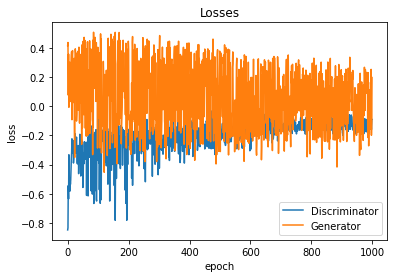

In [41]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

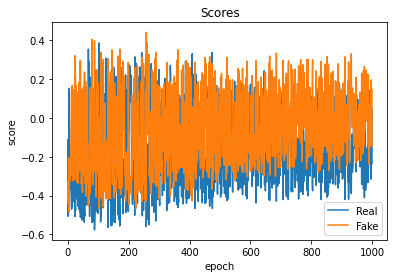

In [42]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');